# LGBM Model
* RNN was far too slow and hence infeasible given the time limit I am constrained within
* So going to use an LGBM
* Just comment out the plots when running if not needing to regenerate them

* <b> REFERENCE: </b>
    * <b>the LGBM implementation in this notebook gained inspiration from the approach shown in prior research done by wenlong: https://github.com/waylongo/cis-challenge-energy-prediction/blob/main/notebooks/modelling-lgb.ipynb </b> 

# Misc / setting up

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import datetime
from IPython.display import display
from pprint import pprint
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
import time
from sklearn import preprocessing
import seaborn as sns
import gc

In [10]:
import random
SEED = 1337
random.seed(SEED)

In [11]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# loading the data

In [12]:
df_train = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all.pkl")
display(df_train)
df_preds = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all_preds.pkl")
display(df_preds)

,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,1,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.5170
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,2.9330
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.0850
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.2370
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,4.4710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640294,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,18.7585
640295,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,21.0110
640296,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,19.2040
640297,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,17.3970


,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,NaN
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,NaN
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,NaN
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,NaN
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,NaN
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,NaN
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,NaN
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,NaN


# formatting the df's

In [13]:
#replacing nans with 0 so we can aggregate up the OOF predictions
df_preds["meter_reading"] = df_preds["meter_reading"].fillna(0) 
#dropping the "energy n-k" columns as they are needed for 3D RNN input not 2D LGBM input
# df_preds = df_preds.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)
# df_train = df_train.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)

display(df_train)
display(df_preds)

,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,1,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.5170
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,2.9330
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.0850
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.2370
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,4.4710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640294,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,18.7585
640295,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,21.0110
640296,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,19.2040
640297,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,17.3970


,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,0


# Ordinally encoding the ID's
* One hot / binary encoding can actually worsen performance of DT based algorithms
* and LGBM supports categorical values; so no need to use the binary encoded meter_id which we planned for the RNN
* Hence I will also now encode the ID ordinally and experiment with both to see which gives the best performing results

In [14]:
#removing the binary encoded ID's as LGBM supports categorical values hence we can just use ordinal encoded ID's for better performance
#commented out for random search as will experiment with using both
# binary_encoded_cols=[]
# for i in range(13):
#     binary_encoded_cols.append(f"meter_id_{i}")
# df_train=df_train.drop(binary_encoded_cols,axis=1)
# df_preds=df_preds.drop(binary_encoded_cols,axis=1)

In [15]:
#ordinally encoding id's
le = preprocessing.LabelEncoder()
le.fit(df_preds["meter_id"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(1, "meter_id_ord", le.transform(df_train["meter_id"]))
df_preds.insert(1, "meter_id_ord", le.transform(df_preds["meter_id"]))

display(df_train)
display(df_preds)

,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1.0,1,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.5170
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,2.9330
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.0850
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.2370
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,4.4710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640294,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,18.7585
640295,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,21.0110
640296,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,19.2040
640297,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1.0,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,17.3970


,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,0


# Ordinally encoding the dwelling_type
* same reasons for replacing the binary encoded meter_id with ordinal encoding; going to replace one hot encodede dwelling type with ordinal encoding

In [16]:
#removing the binary encoded ID's as LGBM supports categorical values hence we can just use ordinal encoded ID's for better performance
# not dropping the orginal random search will experiment with ordinal and onehot
# onehot_encoded_cols = ["detached","flat","terraced","semi_detached"]
# df_train=df_train.drop(onehot_encoded_cols,axis=1)
# df_preds=df_preds.drop(onehot_encoded_cols,axis=1)

In [17]:
#ordinally encoding dwelling_type
le = preprocessing.LabelEncoder()
le.fit(df_preds["dwelling_type"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(27, "dwelling_type_ord", le.transform(df_train["dwelling_type"]))
df_preds.insert(27, "dwelling_type_ord", le.transform(df_preds["dwelling_type"]))

display(df_train)
display(df_preds)

,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,is_weekend,energy_cluster,num_bedrooms,dwelling_type,dwelling_type_ord,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,3.5170
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,2.9330
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,3.0850
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,3.2370
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,4.4710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640294,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,18.7585
640295,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,21.0110
640296,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,19.2040
640297,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,17.3970


,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,is_weekend,energy_cluster,num_bedrooms,dwelling_type,dwelling_type_ord,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,0


# SKF-CV for training the LGBM
* Using skf on df_train by meter_id with 3 folds
    * Meaning for each iteration we use 2/3 of each meters data for training and 1/3 of each meters data for validating
* using out of fold predictions, making predictions on each fold and aggregating them together for the final prediction

* evaluates the model via OOF predictions made on the held out set on each fold
* this score is returned and along with the 3 models
* random search will then be used to find the LGBM hyper param config with the best val score and this will then be used to make predictions using the model which has the best validation score

In [18]:
# REFERENCE the lgbm used inside this function has taken inspiration from the proposed model in the work of Wenlong Wu's : "Solution to the IEEE-CIS Second Technical Challenge with Machine Learning Modeling"

import warnings
warnings.filterwarnings("ignore")

#function for running the cross fold
    #args:
        #disp_fold_info = True if we want to print info for each fold
        #disp_end_info = True if we want to display evaluation info at the end
        #SEED = random seed used for fair repeatability
        #num_folds = number of folds in skf (pretty certain going to keep this at 3 )
        #df_train = training dataframe
        #y_col = the name of the label we want to predict (meter_reading)
        #X_cols = the name of the feature columns we are using
        #X_cat = the name of these features which are categorical
        #params = hyper params for the LGBM model
    #returns:
        #time_of_execution = how long it took to train the model on all folds; will be used as a point of comparison
        #valid_score = MAE calculated using the Out-of-Fold Predictions on the df_train, used for hyper-param tuning
        #lgbm_models = array of the different lgbm_models
        
def run_lgbm_skf_cv(disp_fold_info, disp_end_info, SEED, num_folds, df_train, y_col, X_cols, X_cat, params):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = SEED) # defining the SKF algorithm

    lgbm_models = []
    start_time = time.time()
    fold_iter=1
    #running the startified kfold, splitting df_train by meter_id, so we use 2/3 of each meters reading for training
    for train_index, valid_index in skf.split(df_train, df_train["meter_id"]):

        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Fold {fold_iter}{color.END}")
        
        #splitting into the features and labels for the train and valid folds
        X_train, X_valid = df_train.loc[train_index, X_cols], df_train.loc[valid_index, X_cols]
        y_train, y_valid = df_train.loc[train_index, y_col], df_train.loc[valid_index, y_col]
        
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}X_train{color.END}")
            display(X_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_train{color.END}")
            display(y_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}X_valid{color.END}")
            display(X_valid.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_valid{color.END}")
            display(y_valid.head(5))
            
        print(f"{color.CYAN}{color.UNDERLINE}Training the LGBM{color.END}")
        #instantiating a lgbm regressor with our params
        lgbm_model = lgbm.LGBMRegressor(**params)
        #fitting the lgbm model on the 2/3 train and evaluating on the 1/3 valid
        #printing details every 1000 iters + stopping if no improvement made in 250 iters
        lgbm_model.fit(X_train, y_train,
                       eval_set=[(X_valid, y_valid)],
                       categorical_feature=X_cat,
                       verbose=1000,
                       early_stopping_rounds=250)
        
        #saving the OOF prediction for the held out rows (valid rows from df_train) from the lgbm model with the best performing intrinisic parmams 
        oof_valid = lgbm_model.predict(X_valid, num_iteration=lgbm_model.best_iteration_) # making prediction on the held out rows, X_valid
        df_train.loc[valid_index, "oof"] = oof_valid #storing the oof rows 
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}df_train OOF predictions{color.END}")
            display(df_train.loc[valid_index, ["meter_id","oof"]].head(5))
               
        #appending this lgbm
        lgbm_models.append(lgbm_model)
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}lgbm_models size{color.END}: {len(lgbm_models)}")
            
        fold_iter+=1
        
    
    #calculating execution time and the MAE on the training set
    time_of_execution = time.time() - start_time
    valid_score=mean_absolute_error(df_train[y_col], df_train["oof"]) 
    
    if(disp_end_info):
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}training set OOF preds vs true{color.END}")
        display(df_train[["meter_id","date","meter_reading","oof"]])
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(time_of_execution)))}\n")
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {valid_score}\n")
    
    
    
    
    return (time_of_execution, valid_score, lgbm_models)


# Running random search on the LGBM skf-cv function
* going to run random search to find the hyper param config which gav the best MAE on OOF predictions on the train ste in skf-cv
    * originally implemented grid search in an earlier commit but it was incredibly slow due to the exponential growth from the wide range of hyper paramaeters
        * decided to use random search has it has been proven to be more efficient than grid search in research eg in the paper" Random search for hyper-parameter optimization" (James bergstra et al. 2012 Montreal)


In [19]:
y_col = "meter_reading" #we want to predict the meter_reading (this will always be the same)

## Setting the column types and grouping ones together that should be grouped
* Not specifying configurations anymore letting random search pick them itself

In [20]:
#dictionary to hold all groups of columns which could be chosen
#done as if we just pick columns completely random we may get just "meter_id_3" from the binary encoded meter_id's
#wouldn't make any sense without the other respective binary encoded meter_id columns

possible_columns = {}
possible_columns["meter_id_ord"] = ["meter_id_ord"]
possible_columns["meter_id_binary"] = ['meter_id_0', 'meter_id_1', 'meter_id_2',
       'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
       'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12']
possible_columns["day_of_year_cyclic"] = ["day_of_year_sin","day_of_year_cos"]
possible_columns["day_of_week"] = ["day_of_week"]
possible_columns["day_of_month"] = ["day_of_month"]
possible_columns["month_ord"] = ["month_ord"]
possible_columns["month_cyclic"] = ["month_sin","month_cos"]
possible_columns["is_weekend"] = ["is_weekend"]
possible_columns["energy_cluster"] = ["energy_cluster"]
possible_columns["num_bedrooms"] = ["num_bedrooms"]
possible_columns["dwelling_type_ord"] = ["dwelling_type_ord"]
possible_columns["dwelling_type_onehot"] = ['detached', 'flat', 'semi_detached', 'terraced']
pprint(possible_columns)

{'day_of_month': ['day_of_month'],
 'day_of_week': ['day_of_week'],
 'day_of_year_cyclic': ['day_of_year_sin', 'day_of_year_cos'],
 'dwelling_type_onehot': ['detached', 'flat', 'semi_detached', 'terraced'],
 'dwelling_type_ord': ['dwelling_type_ord'],
 'energy_cluster': ['energy_cluster'],
 'is_weekend': ['is_weekend'],
 'meter_id_binary': ['meter_id_0',
                     'meter_id_1',
                     'meter_id_2',
                     'meter_id_3',
                     'meter_id_4',
                     'meter_id_5',
                     'meter_id_6',
                     'meter_id_7',
                     'meter_id_8',
                     'meter_id_9',
                     'meter_id_10',
                     'meter_id_11',
                     'meter_id_12'],
 'meter_id_ord': ['meter_id_ord'],
 'month_cyclic': ['month_sin', 'month_cos'],
 'month_ord': ['month_ord'],
 'num_bedrooms': ['num_bedrooms']}


In [21]:
# setting categorical columns

all_cat = ["meter_id_ord", 'meter_id_0', 'meter_id_1', 'meter_id_2',
           'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
           'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12',
           "day_of_week", "day_of_month", "month_ord", "is_weekend", "energy_cluster",
           "dwelling_type_ord", "detached", "flat", "semi_detached", "terraced"] #all categorical values

# setting categorical columns in the dataframe to be categorical
#X_cat[0] holds all columns (besides clusters but we aren't using that) 
for i in all_cat:
    df_train[i] = df_train[i].astype('category')
    df_preds[i] = df_preds[i].astype('category')

### Defining the model parameters for random search
* sensible different combinations of params for the model

* default values which make sense and the others have place holders as they will be found in random search

In [22]:
#default params (including ones we will override and those we won't)
params = {
    ### won't be tuned ###
    'boosting_type': 'gbdt', #gbdt/rf/dart/goss
    'metric': 'mae', 
    'num_threads': -1, # number of threads to run on for speed (auto)
    'num_iterations': 10000, #defining the models runs
    'seed': SEED, # all runs with same seed for better comparison between different hyper params

    
    ### will be tuned (replace these with the best performing) ###
    'learning_rate': 0.99999,
    'num_leaves': 99999, # limit max numer of leaves in a tree
    "max_depth":99999, # limit max depth of the tree to prevent overfitting
    # fraction to be bagged/sampled every k iterations
    'bagging_fraction': 0.99999,
    'bagging_freq' : 99999,
    'feature_fraction': 0.99999, # fraction of features to use at each tree node
    #l1 & l2 regularization to prevent overfitting
    "lambda_l1": 99999,
    "lambda_l2": 99999
}

pprint(params)

{'bagging_fraction': 0.99999,
 'bagging_freq': 99999,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.99999,
 'lambda_l1': 99999,
 'lambda_l2': 99999,
 'learning_rate': 0.99999,
 'max_depth': 99999,
 'metric': 'mae',
 'num_iterations': 100,
 'num_leaves': 99999,
 'num_threads': -1,
 'seed': 1337}


## Running the random search

In [15]:
num_folds = 3 # 3 fold skf; so we use 2/3 of each meters readings for training at each iteration 
i=0 #just used to print the index of each skf-cv run
all_results = [] # will hold array of all the tuples of results + hyper params

#random search
print(f"{color.BOLD}Running random search hyper parameter optimization{color.END}\n")
start_time = time.time()
#going to test n hyper parameter configurations
n=64
for i in tqdm(range(n)):
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}skf-cv LGBM run {i}{color.END}")
    #### randomly generate the hyper parameters for this model within a sensible range for each ####

    #firstly randomly picking the features we will use
    print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Picking random features{color.END}")
    X_cols = []#this will store the X_cols we use

    #generating probability of accepting each column
    prob_to_beat = random.randrange(30,100)/100 #between 0.3 and 1
    #iterating through each column and randomly decide whether or not to pick it
    for key in possible_columns.keys():
        #randomly generate a decimal for this column group
        this_prob = random.randrange(0,100)/100 #between 0 and 1
        #if this is less than the probability to beat then accept it
        if(this_prob<=prob_to_beat):
            print(key,this_prob,"<=",prob_to_beat)
            X_cols+=(possible_columns[key])
    #if this has 0 columns then add 1 randomly
    if(len(X_cols)<=0):
        new_key=random.choice(list(possible_columns.keys()))
        X_cols+=possible_columns[new_key]
        print(f"No columns clipping length to 1 so randomly choosing to use {new_key}")
        
    print(X_cols)
    
    this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
    
    print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Picking random hyper parameters{color.END}")
    #then get LGBM hyper parameters
    this_params = params.copy()
#     this_params["learning_rate"] = random.randrange(10,25)/1000 #between 0.01 and 0.025
#     this_params["max_depth"] = random.randrange(6,12)
#     this_params["num_leaves"] = random.randrange(np.round(2**(this_params["max_depth"])*0.5), np.round(2**(this_params["max_depth"])*0.9)) #picking a random max leaves less than 2^(max_depth) to prevent over fitting (between 50 and 90%)
#     this_params["bagging_fraction"] = random.randrange(65,90)/100 #between 0.65 and 0.9
#     this_params["bagging_freq"] = random.randrange(5,25)
#     this_params["feature_fraction"] = random.randrange(65,90)/100 #between 0.65 and 0.9
#     this_params["lambda_l1"] = random.randrange(8,18)
#     this_params["lambda_l2"] = random.randrange(4,14)
    this_params["learning_rate"] = random.randrange(10,100)/1000 #between 0.01 and 0.1
    this_params["max_depth"] = random.randrange(6,12)
    this_params["num_leaves"] = random.randrange(np.round(2**(this_params["max_depth"])*0.5), np.round(2**(this_params["max_depth"])*1)) #picking a random max leaves less than 2^(max_depth) to prevent over fitting (between 50 and 100%)
    this_params["bagging_fraction"] = random.randrange(50,100)/100 #between 0.5 and 1
    this_params["bagging_freq"] = random.randrange(5,25)
    this_params["feature_fraction"] = random.randrange(50,100)/100 #between 0.5 and 1
    this_params["lambda_l1"] = random.randrange(4,20)
    this_params["lambda_l2"] = random.randrange(4,20)

    fail_counter=1
    while True:
            #try to run this model
            try:
                pprint(this_params)
                all_results.append((run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params),(X_cols,this_params)))                
                break
            #if it fails randomise value of feature fraction as it seems the bug that exists in lgbm library that is unpatched is depending on the feature fraction value https://github.com/microsoft/LightGBM/issues/3679
            except:
                print(f"Individual {i} failed {fail_counter} times")
                random_new_frac=random.randrange(0,100)/100
                print(f"Changing feature fraction from {this_params['feature_fraction']} to {random_new_frac}")
                this_params["feature_fraction"]=random_new_frac
                fail_counter+=1
    
    

    #train the model with this hyper param config and store it's results

   
    print("\n\n\n")
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Random search ran {n} iterations in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n")

Running random search hyper parameter optimization



  0%|          | 0/64 [00:00<?, ?it/s]

skf-cv LGBM run 0
Picking random features
meter_id_ord 0.9 <= 0.98
meter_id_binary 0.46 <= 0.98
day_of_year_cyclic 0.73 <= 0.98
day_of_week 0.74 <= 0.98
day_of_month 0.93 <= 0.98
month_ord 0.21 <= 0.98
is_weekend 0.42 <= 0.98
energy_cluster 0.49 <= 0.98
num_bedrooms 0.81 <= 0.98
dwelling_type_ord 0.46 <= 0.98
dwelling_type_onehot 0.39 <= 0.98
['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'day_of_month', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
Picking random hyper parameters
{'bagging_fraction': 0.98,
 'bagging_freq': 16,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.56,
 'lambda_l1': 17,
 'lambda_l2': 16,
 'learning_rate': 0.06,
 'max_depth': 11,
 'metric': 'mae',
 'num_iterations': 10000

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.91821
[2000]	valid_0's l1: 2.83446
[3000]	valid_0's l1: 2.8013
[4000]	valid_0's l1: 2.77941
[5000]	valid_0's l1: 2.76421
[6000]	valid_0's l1: 2.75243
[7000]	valid_0's l1: 2.74294
[8000]	valid_0's l1: 2.73563
[9000]	valid_0's l1: 2.72976
[10000]	valid_0's l1: 2.72379
Did not meet early stopping. Best iteration is:
[9999]	valid_0's l1: 2.72379
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.62, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.62
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.02134
[2000]	valid_0's l1: 2.00058
[3000]	valid_0's l1: 1.98607
[4000]	valid_0's l1: 1.97607
[5000]	valid_0's l1: 1.96681
[6000]	valid_0's l1: 1.9637
[7000]	valid_0's l1: 1.96063
[8000]	valid_0's l1: 1.95843
[9000]	valid_0's l1: 1.95689
Early stopping, best iteration is:
[8854]	valid_0's l1: 1.95657
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.66, subsample=1.0 will be ignored. Current value: bagging_fraction=0.66
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=7, 

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.04346
[2000]	valid_0's l1: 1.97359
[3000]	valid_0's l1: 1.93834
[4000]	valid_0's l1: 1.91257
[5000]	valid_0's l1: 1.8962
[6000]	valid_0's l1: 1.8827
[7000]	valid_0's l1: 1.87136
[8000]	valid_0's l1: 1.86231
[9000]	valid_0's l1: 1.8542
[10000]	valid_0's l1: 1.84766
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.84766
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14


[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.79, subsample=1.0 will be ignored. Current value: bagging_fraction=0.79
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.12708
[2000]	valid_0's l1: 2.06638
[3000]	valid_0's l1: 2.03724
[4000]	valid_0's l1: 2.01897
[5000]	valid_0's l1: 2.00539
[6000]	valid_0's l1: 1.99539
[7000]	valid_0's l1: 1.98667
[8000]	valid_0's l1: 1.97931
[9000]	valid_0's l1: 1.97278
[10000]	valid_0's l1: 1.96746
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.96746
Fold 3
Training the LGBM
[LightGBM] [War

[9000]	valid_0's l1: 1.92764
[10000]	valid_0's l1: 1.92436
Did not meet early stopping. Best iteration is:
[9996]	valid_0's l1: 1.92436
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.68, subsample=1.0 will be ignored. Current value: bagging_fraction=0.68
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.02184
[2000]	valid_0's l1: 1.98045
[3000]	valid_0's l1: 1.96234
[4000]	valid_0's l1: 1.95091
[5000]

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.06803
[2000]	valid_0's l1: 1.98718
[3000]	valid_0's l1: 1.94344
[4000]	valid_0's l1: 1.91537
[5000]	valid_0's l1: 1.89549
[6000]	valid_0's l1: 1.879
[7000]	valid_0's l1: 1.86596
[8000]	valid_0's l1: 1.85445
[9000]	valid_0's l1: 1.84478
[10000]	valid_0's l1: 1.83639
Did not meet early stopping. Best iteration is:
[9966]	valid_0's l1: 1.83638
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[L

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.14225
[2000]	valid_0's l1: 2.04604
[3000]	valid_0's l1: 2.00551
[4000]	valid_0's l1: 1.97907
[5000]	valid_0's l1: 1.95839
[6000]	valid_0's l1: 1.94161
[7000]	valid_0's l1: 1.92741
[8000]	valid_0's l1: 1.91455
[9000]	valid_0's l1: 1.90347
[10000]	valid_0's l1: 1.89386
Did not meet early stopping. Best iteration is:
[9995]	valid_0's l1: 1.89386
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.43026
[2000]	valid_0's l1: 2.35478
[3000]	valid_0's l1: 2.31033
[4000]	valid_0's l1: 2.28464
[5000]	valid_0's l1: 2.26081
[6000]	valid_0's l1: 2.24709
[7000]	valid_0's l1: 2.23466
[8000]	valid_0's l1: 2.22522
[9000]	valid_0's l1: 2.21846
[10000]	valid_0's l1: 2.20924
Did not meet early stopping. Best iteration is:
[9992]	valid_0's l1: 2.20921




skf-cv LGBM run 17
Picking random features
meter_id_ord 0.36 <= 0.71
meter_id_binary 0.06 <= 0.71
day_of_week 0.62 <= 0.71
day_of_month 0.46 <= 0.71
month_ord 0.41 <= 0.71
month_cyclic 0.03 <= 0.71
energy_cluster 0.46 <= 0.71
dwelling_type_onehot 0.42 <= 

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.95639
[2000]	valid_0's l1: 1.9373
[3000]	valid_0's l1: 1.92804
[4000]	valid_0's l1: 1.92135
[5000]	valid_0's l1: 1.9174
[6000]	valid_0's l1: 1.91432
[7000]	valid_0's l1: 1.91182
[8000]	valid_0's l1: 1.90946
[9000]	valid_0's l1: 1.90774
Early stopping, best iteration is:
[9681]	valid_0's l1: 1.90634




skf-cv LGBM run 19
Picking random features
meter_id_binary 0.47 <= 0.76
day_of_year_cyclic 0.04 <= 0.76
day_of_week 0.18 <= 0.76
day_of_month 0.18 <= 0.76
month_ord 0.13 <= 0.76
month_cyclic 0.29 <= 0.76
energy_cluster 0.52 <= 0.76
num_bedrooms 0.2 <= 0.76
dwelling_type_ord 0.17 <= 0.76
dwelling_type_onehot 0.25 <= 0.76
['meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'day_of_month', 'month_ord', 'month_sin', 'month_c

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.61, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.61
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.55, subsample=1.0 will be ignored. Current value: bagging_fraction=0.55
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.96028
[2000]	valid_0's l1: 1.924
[3000]	valid_0's l1: 1.90165
[4000]	valid_0's l1: 1.88692
[5000]	valid_0's l1: 1.87483
[6000]	valid_0's l1: 1.86487
[7000]	valid_0's l1: 1.85652
[8000]	valid_0's l1: 1.85022
[9000]	valid_0's l1: 1.8

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.87, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.87
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.98303
[2000]	valid_0's l1: 2.92692
[3000]	valid_0's l1: 2.89137
[4000]	valid_0's l1: 2.87868
Early stopping, best iteration is:
[4730]	valid_0's l1: 2.87103
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.87, 

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 4.60666
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.82, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 4.60668
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 3.75181
[2000]	valid_0's l1: 3.62209
[3000]	valid_0's l1: 3.5453
[4000]	valid_0's l1: 3.49547
[5000]	valid_0's l1: 3.45285
[6000]	valid_0's l1: 3.41834
[7000]	valid_0's l1: 3.39451
[8000]	valid_0's l1: 3.36984
[9000]	valid_0's l1: 3.35082
[10000]	valid_0's l1: 3.33469
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 3.33469
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.88, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.88
[LightGBM] [Warning] lambda_l1 is set=13, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.99419
[2000]	valid_0's l1: 1.97734
[3000]	valid_0's l1: 1.96995
[4000]	valid_0's l1: 1.96446
Early stopping, best iteration is:
[4148]	valid_0's l1: 1.96363
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.86, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.86
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
[LightGBM] [Warning] bagging_fraction is set=0.51, subsample=1.0 will be ignored. Current value: bagging_fraction=0.51
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=19, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
Training until validation scores don't improve for 250 rounds
[1000]	valid

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.15419
[2000]	valid_0's l1: 2.08884
[3000]	valid_0's l1: 2.06332
[4000]	valid_0's l1: 2.04414
[5000]	valid_0's l1: 2.03282
[6000]	valid_0's l1: 2.0217
[7000]	valid_0's l1: 2.01117
[8000]	valid_0's l1: 2.00391
[9000]	valid_0's l1: 1.99832
[10000]	valid_0's l1: 1.99227
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.99227
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.69, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.69
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1

Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.83766
[2000]	valid_0's l1: 1.80988
[3000]	valid_0's l1: 1.79285
[4000]	valid_0's l1: 1.78023
[5000]	valid_0's l1: 1.7702
[6000]	valid_0's l1: 1.76302
[7000]	valid_0's l1: 1.75658
[8000]	valid_0's l1: 1.75143
[9000]	valid_0's l1: 1.7469

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.99367
[2000]	valid_0's l1: 1.96992
[3000]	valid_0's l1: 1.95977
[4000]	valid_0's l1: 1.95242
[5000]	valid_0's l1: 1.94736
[6000]	valid_0's l1: 1.94378
[7000]	valid_0's l1: 1.94055
[8000]	valid_0's l1: 1.93794
Early stopping, best iteration is:
[8343]	valid_0's l1: 1.93705
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.96, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.64, subsample=1.0 will be ignored. Current value: bagging_fraction=0.64
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ign

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.18523
[2000]	valid_0's l1: 2.126
[3000]	valid_0's l1: 2.10467
[4000]	valid_0's l1: 2.09004
[5000]	valid_0's l1: 2.07924
[6000]	valid_0's l1: 2.07162
[7000]	valid_0's l1: 2.06311
[8000]	valid_0's l1: 2.05682
[9000]	valid_0's l1: 2.05255
[10000]	valid_0's l1: 2.05052
Did not meet early stopping. Best iteration is:
[9768]	valid_0's l1: 2.05027
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.78, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.78
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.77, subsample=1.0 will be ignored. Current value: bagging_fraction=0.77
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13


Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.98591
[2000]	valid_0's l1: 1.97946
Early stopping, best iteration is:
[2155]	valid_0's l1: 1.97863
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.99441
Early stopping, best iteration is:
[1690]	v

[8000]	valid_0's l1: 1.93721
[9000]	valid_0's l1: 1.9325
[10000]	valid_0's l1: 1.92889
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.92889
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.63, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.63
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.04237
[2000]	valid_0's l1: 2.00418
[3000]	valid_0's l1: 1.98283
[4000]

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 4.21288
[2000]	valid_0's l1: 4.09488
[3000]	valid_0's l1: 4.03554
[4000]	valid_0's l1: 3.98659
[5000]	valid_0's l1: 3.94622
[6000]	valid_0's l1: 3.91386
[7000]	valid_0's l1: 3.88715
[8000]	valid_0's l1: 3.87113
[9000]	valid_0's l1: 3.85624
[10000]	valid_0's l1: 3.8401
Did not meet early stopping. Best iteration is:
[9997]	valid_0's l1: 3.84005
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is set=19, reg_alpha=0.0 will be ignored. Current value: lambda_l1=19
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[533]	valid_0's l1: 2.26322
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.83, subsample=1.0 will be ignored. Current value: bagging_fraction=0.83
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[652]	valid_0's l1: 2.2633




skf-cv LGBM run 46
Picking random features
meter_id_ord 0.18 <= 0

[1000]	valid_0's l1: 2.94871
[2000]	valid_0's l1: 2.85631
[3000]	valid_0's l1: 2.83309
Early stopping, best iteration is:
[2971]	valid_0's l1: 2.83175
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.58, subsample=1.0 will be ignored. Current value: bagging_fraction=0.58
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.91896
[2000]	valid_0's l1: 2.84502
[3000]	valid_0's l1: 2.8268
[4000]	valid_0's l1: 

Early stopping, best iteration is:
[7070]	valid_0's l1: 1.922
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.96, subsample=1.0 will be ignored. Current value: bagging_fraction=0.96
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.95471
[2000]	valid_0's l1: 1.94484
[3000]	valid_0's l1: 1.94033
[4000]	valid_0's l1: 1.9371
[5000]	valid_0's l1: 1.9346
[6000]	valid_0's l1: 1.93241
[7000]	valid_0's l1: 1

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.57363
[2000]	valid_0's l1: 2.52342
[3000]	valid_0's l1: 2.50026
[4000]	valid_0's l1: 2.48699
[5000]	valid_0's l1: 2.47388
[6000]	valid_0's l1: 2.46428
[7000]	valid_0's l1: 2.45774
[8000]	valid_0's l1: 2.45337
[9000]	valid_0's l1: 2.44879
[10000]	valid_0's l1: 2.44419
Did not meet early stopping. Best iteration is:
[9880]	valid_0's l1: 2.44399
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.94, subsample=1.0 will be ignored. Current value: bagging_fraction=0.94
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.24142
[2000]	valid_0's l1: 2.20631
[3000]	valid_0's l1: 2.18925
[4000]	valid_0's l1: 2.18293
Early stopping, best iteration is:
[4248]	valid_0's l1: 2.18039
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.94, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.94
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.62, subsample=1.0 will be ignored. Current value: bagging_fraction=0.62
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[78]	valid_0's l1: 4.64403




skf-cv LGBM run 56
Picking random features
meter_id_ord 0.22 <= 0.35
month_ord 0.18 <= 0.35
num_bedrooms 0.28 <= 0.35
dwelling_type_ord 0.04 <= 0.35
dwelling_type_onehot 0.09 <= 0.35
['meter_id_ord', 'month_ord', 'num_bedrooms', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
Picking random hyper parameters
{'bagging_fraction': 0.87,
 'bagging_freq': 6,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.61,
 'lambda_l1': 8,
 'lambda_l2': 16,
 'learning_rate': 0.079,
 'max_depth': 11,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 1265,
 'num_threads': -1,
 'seed': 1337}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.61, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.61
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [W

[1000]	valid_0's l1: 1.97063
[2000]	valid_0's l1: 1.92079
[3000]	valid_0's l1: 1.89339
[4000]	valid_0's l1: 1.87312
[5000]	valid_0's l1: 1.85734
[6000]	valid_0's l1: 1.84546
[7000]	valid_0's l1: 1.83439
[8000]	valid_0's l1: 1.82713
[9000]	valid_0's l1: 1.82003
[10000]	valid_0's l1: 1.81374
Did not meet early stopping. Best iteration is:
[9960]	valid_0's l1: 1.81374




skf-cv LGBM run 58
Picking random features
meter_id_ord 0.34 <= 0.77
meter_id_binary 0.27 <= 0.77
day_of_year_cyclic 0.38 <= 0.77
day_of_week 0.25 <= 0.77
day_of_month 0.43 <= 0.77
month_ord 0.17 <= 0.77
energy_cluster 0.4 <= 0.77
dwelling_type_ord 0.69 <= 0.77
dwelling_type_onehot 0.58 <= 0.77
['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'day_of_month', 'month_ord', 'energy_cluster', 'dwelling_type_ord', 'detached

Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] bagging_fraction is set=0.79, subsample=1.0 will be ignored. Current value: bagging_fraction=0.79
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 2.11448
[2000]	valid_0's l1: 2.07431
[3000]	valid_0's l1: 2.04919
[4000]	valid_0's l1: 2.03433
[5000]	valid_0's l1: 2.02273
[6000]	valid_0's l1: 2.01518
[7000]	valid_0's l1: 2.00841
[8000]	valid_0's l1: 2.00311
[9000]	valid_0's l1: 1.99914
[10000

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.8525
[2000]	valid_0's l1: 1.82168
[3000]	valid_0's l1: 1.80509
[4000]	valid_0's l1: 1.79416
[5000]	valid_0's l1: 1.78744
[6000]	valid_0's l1: 1.78109
[7000]	valid_0's l1: 1.77587
[8000]	valid_0's l1: 1.77142
[9000]	valid_0's l1: 1.76805
[10000]	valid_0's l1: 1.76497
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.76497




skf-cv LGBM run 62
Picking random features
meter_id_binary 0.3 <= 0.38
day_of_year_cyclic 0.13 <= 0.38
day_of_week 0.3 <= 0.38
dwelling_type_ord 0.21 <= 0.38
['meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'dwelling_type_ord']
Picking random hyper parameters
{'bagging_fraction': 0.69,
 'bagging_freq': 16,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.66,
 'lambda_l1': 1

Training until validation scores don't improve for 250 rounds
[1000]	valid_0's l1: 1.98184
[2000]	valid_0's l1: 1.95639
[3000]	valid_0's l1: 1.94239
[4000]	valid_0's l1: 1.93272
[5000]	valid_0's l1: 1.92621
[6000]	valid_0's l1: 1.92056
[7000]	valid_0's l1: 1.91565
[8000]	valid_0's l1: 1.9117
[9000]	valid_0's l1: 1.90866
[10000]	valid_0's l1: 1.90566
Did not meet early stopping. Best iteration is:
[9998]	valid_0's l1: 1.90566




Random search ran 64 iterations in 22:01:47



## Visualising information from the random search results
### Box plots of the MAE for the different columns

  0%|          | 0/12 [00:00<?, ?it/s]

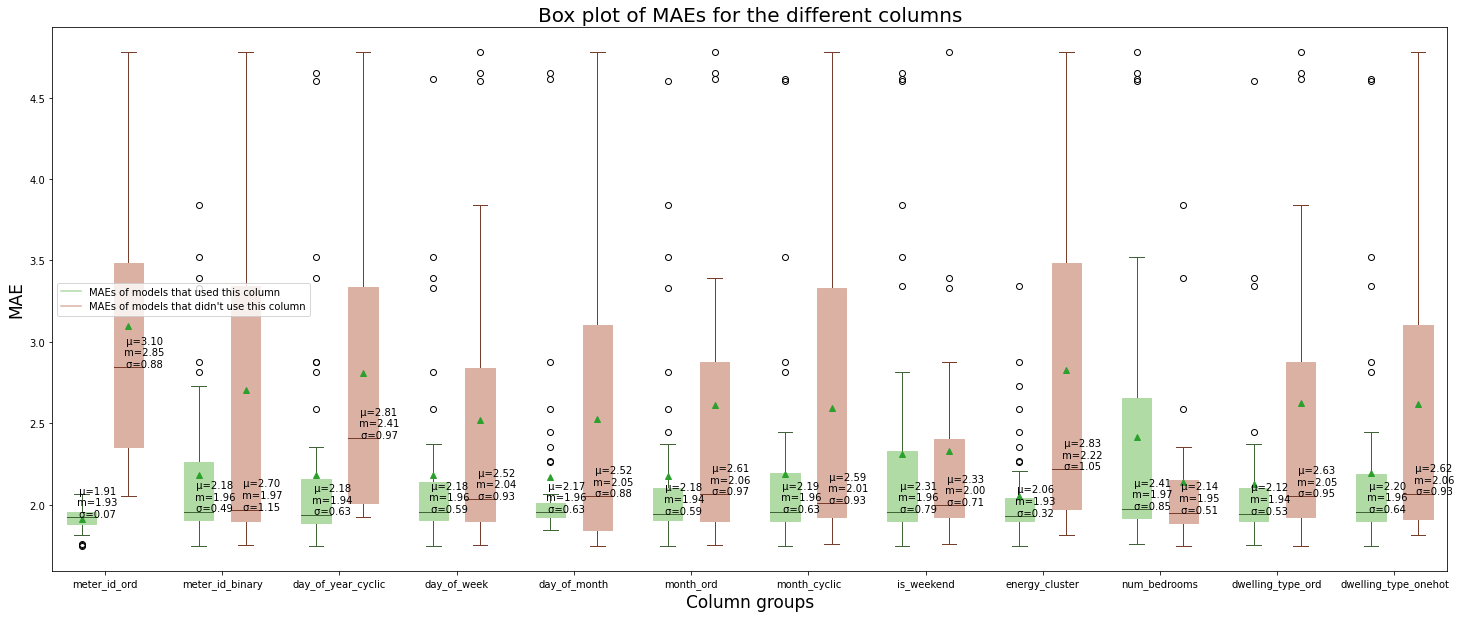

10

In [16]:
columns_maes = {} #dictionary of each columns maes
columnless_mae = {}
#iterating through each column and randomly decide whether or not to pick it
for key in tqdm(possible_columns.keys()):
    column = possible_columns[key][0] # only want to check against one column for the 'in'
    
    # if this column doesn't yet exist in the dict, create it
    if key not in columns_maes:
        columns_maes[key]=[]
    # if this column doesn't yet exist in the dict, create it
    if key not in columnless_mae:
        columnless_mae[key]=[]

    #iterating through every single models results
    for i in range(len(all_results)):
        
        #if this column was used by the model
        if column in all_results[i][1][0]:
            # adding this models mae to the dict entry for this column
            columns_maes[key].append(all_results[i][0][1])
            
        #else this column wasn't used by the model
        else:
            # adding this models mae to the dict entry for this column
            columnless_mae[key].append(all_results[i][0][1])

# print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}MAEs for each model which contains columns of each type{color.END}")
# pprint(columns_maes)

# function for setting the box colour
def set_box_color(bp, color_line, color_fill):
    plt.setp(bp['whiskers'], color=color_line)
    plt.setp(bp['caps'], color=color_line)
    plt.setp(bp['medians'], color=color_line)
    plt.setp(bp['fliers'], color=color_fill)
    plt.setp(bp['boxes'], color=color_fill)
    plt.setp(bp['means'], color=color_line)

    
### plotting a boxplot of these ###
# getting the 2 dicts we will plot
labels, data_columns = columns_maes.keys(), columns_maes.values()
data_columnless = columnless_mae.values()

#plotting these 2 dicts next to each other
fig = plt.figure(figsize=(25,10))
bp_dict_columns = plt.boxplot(data_columns,showmeans=True,positions=np.array(range(len(labels)))*2.0-0.4,patch_artist=True) # getting dictionary returned from boxplot
bp_dict_columnless = plt.boxplot(data_columnless,showmeans=True,positions=np.array(range(len(labels)))*2.0+0.4,patch_artist=True) # getting dictionary returned from boxplot

#colouring them
set_box_color(bp_dict_columns, '#416338','#b0dba4')
set_box_color(bp_dict_columnless, '#783d2b','#dbb1a4')

#annotating the plot
plt.title("Box plot of MAEs for the different columns", fontsize=20)
plt.xlabel("Column groups", fontsize=17)
plt.ylabel("MAE", fontsize=17)

#creating the legend
plt.plot([], c='#b0dba4',label="MAEs of models that used this column")
plt.plot([], c='#dbb1a4',label="MAEs of models that didn't use this column")
plt.legend()


## adding overlayed values to the boxplot

# stats for with columns
column_means = []
column_medians = []
column_std = []
for key in columns_maes.keys():
    column_means.append(np.mean(columns_maes[key]))
    column_medians.append(np.median(columns_maes[key]))
    column_std.append(np.std(columns_maes[key]))
for i, line in enumerate(bp_dict_columns['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n m={:.2f}\n σ={:.2f}'.format(column_means[i], column_medians[i], column_std[i])
    plt.text(x, y, text, horizontalalignment='center')
    
# stats for without columns
columnless_means = []
columnless_medians = []
columnless_std = []
for key in columnless_mae.keys():
    columnless_means.append(np.mean(columnless_mae[key]))
    columnless_medians.append(np.median(columnless_mae[key]))
    columnless_std.append(np.std(columnless_mae[key]))
for i, line in enumerate(bp_dict_columnless['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n m={:.2f}\n σ={:.2f}'.format(columnless_means[i], columnless_medians[i], columnless_std[i])
    plt.text(x, y, text, horizontalalignment='center')


plt.xticks(range(0, len(labels)*2,2), labels)

plt.show()

fig.savefig(f"..\\Results\\Unclustered Random Search\\Plots\\{n}_Box_MAEs.png")

plt.close(fig)
del fig
gc.collect()

## Box and swarm plot to better inspect the distribution

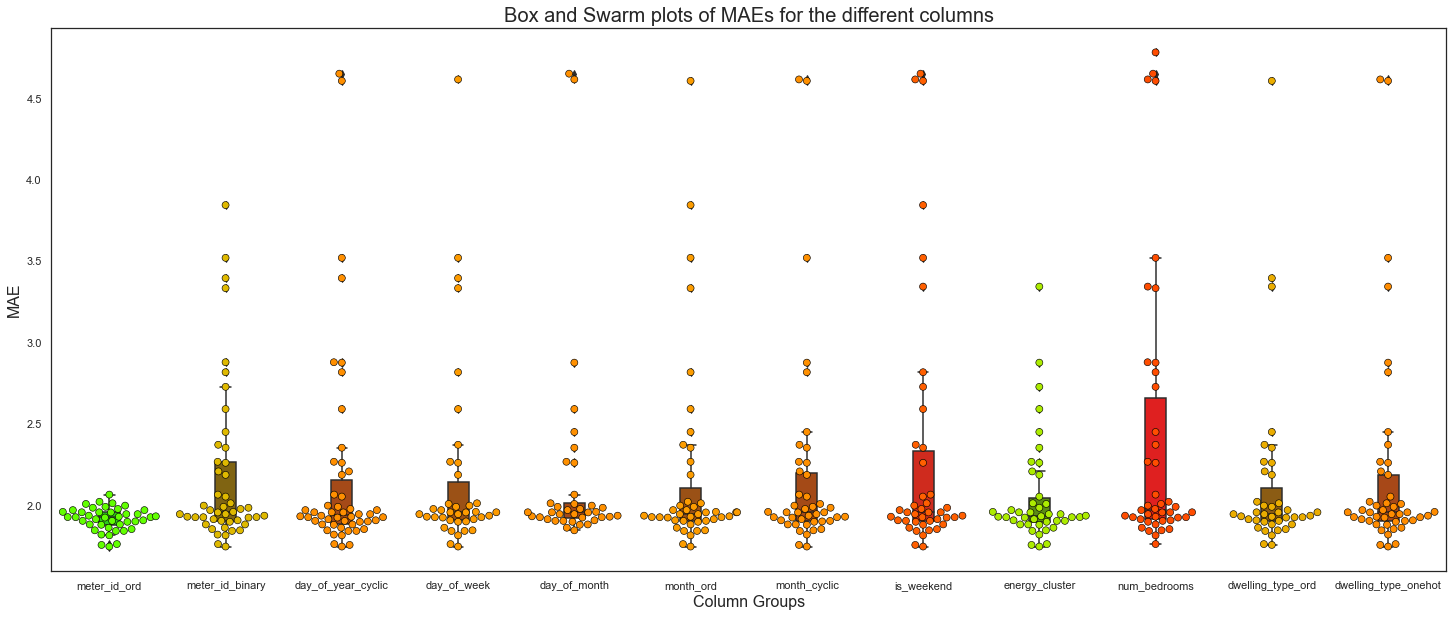

10969

In [17]:
colourBlindFriendly = False # make graph colourBlindFriendly (pink to blue instead of red to green)

#normalizing the std
max_std = max(column_std)
column_std = [float(i)/max_std for i in column_std]

#gradient of green to red based on each columns stats
box_grad_palette = {}
for i in range(len(column_std)):
    box_grad_palette[i] = [column_std[i], 1-column_std[i],1 if colourBlindFriendly else 0] #based on std

fig=plt.figure(figsize=(25,10))
sns.set(context='notebook', style='white')
sns.utils.axlabel(xlabel="Column Groups", ylabel="MAE", fontsize=16)
sns.boxplot(data=list(data_columns), width=.18, palette=box_grad_palette)

#slightly paler gradient to make it stand out from the box
swarm_grad_palette = box_grad_palette.copy()
for i in range(len(swarm_grad_palette)):
    #fading it to white
    #adding to red to make it paler
    swarm_grad_palette[i][0] = swarm_grad_palette[i][0]+0.3 if swarm_grad_palette[i][0]+0.3<1 else 1
    #adding to green to make it paler
    swarm_grad_palette[i][1] = swarm_grad_palette[i][1]+0.3 if swarm_grad_palette[i][1]+0.3<1 else 1
    #adding to blue to make it paler
    if colourBlindFriendly:
        swarm_grad_palette[i][2] = swarm_grad_palette[i][2]+0.3 if swarm_grad_palette[i][2]+0.3<1 else 1


sns.swarmplot(data=list(data_columns), size=7, edgecolor="black", linewidth=.6, palette=swarm_grad_palette)

plt.xticks(plt.xticks()[0], labels)

plt.title("Box and Swarm plots of MAEs for the different columns", fontsize=20)

plt.show()
fig.savefig(f"..\\Results\\Unclustered Random Search\\Plots\\{n}_BoxSwarm_MAEs_GRAD_STD.png")
plt.close(fig)
del fig
gc.collect()

### Main Effects Plots

  0%|          | 0/8 [00:00<?, ?it/s]

,learning_rate,MAE
37,0.089,1.757765


[array([0.089])]


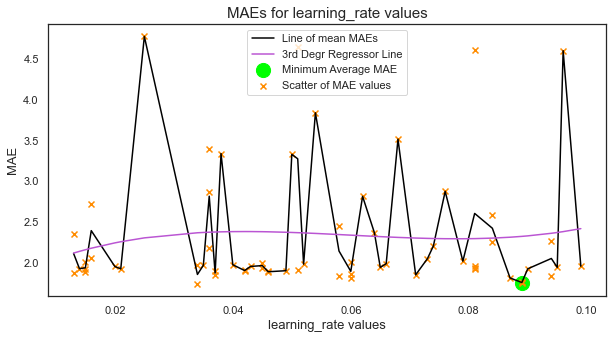

,num_leaves,MAE
44,958.0,1.745217


[array([0.089]), array([958.])]


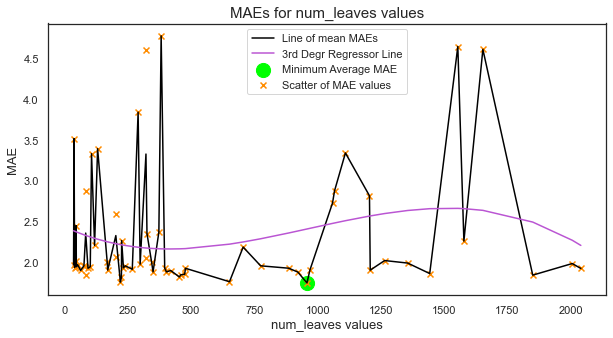

,max_depth,MAE
4,10.0,1.908332


[array([0.089]), array([958.]), array([10.])]


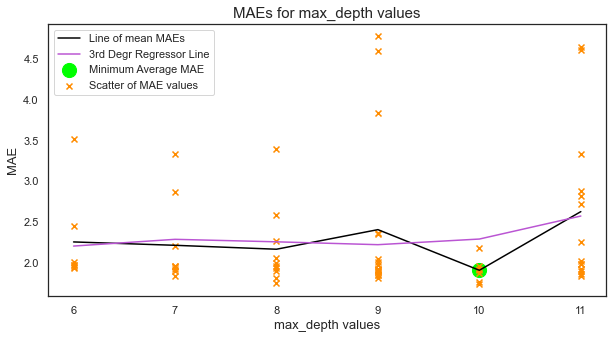

,bagging_fraction,MAE
31,0.89,1.760387


[array([0.089]), array([958.]), array([10.]), array([0.89])]


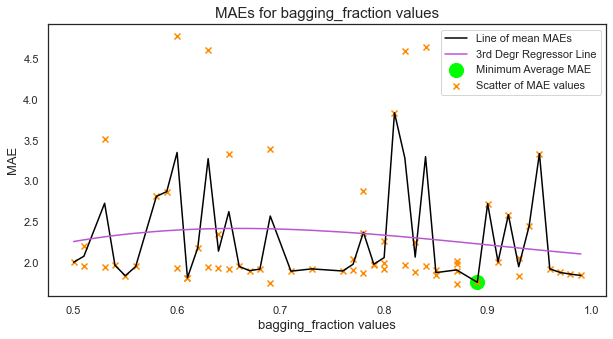

,bagging_freq,MAE
7,12.0,1.833391


[array([0.089]), array([958.]), array([10.]), array([0.89]), array([12.])]


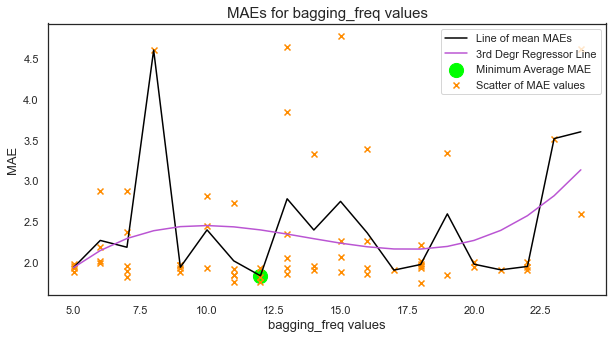

,feature_fraction,MAE
19,0.74,1.760387


[array([0.089]), array([958.]), array([10.]), array([0.89]), array([12.]), array([0.74])]


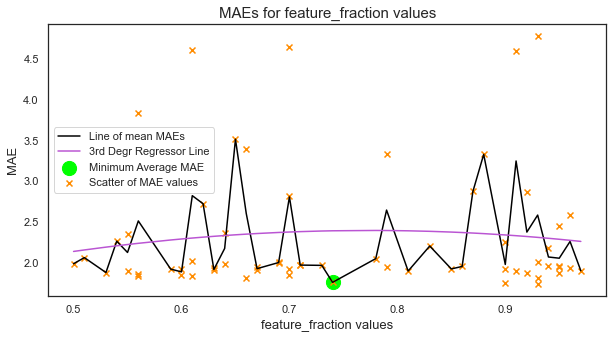

,lambda_l1,MAE
10,14.0,1.881188


[array([0.089]), array([958.]), array([10.]), array([0.89]), array([12.]), array([0.74]), array([14.])]


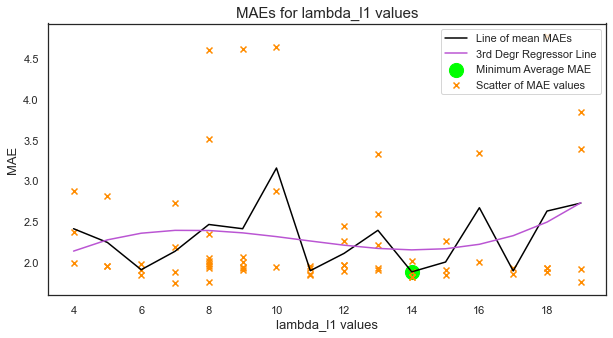

,lambda_l2,MAE
3,8.0,1.7977


[array([0.089]), array([958.]), array([10.]), array([0.89]), array([12.]), array([0.74]), array([14.]), array([8.])]


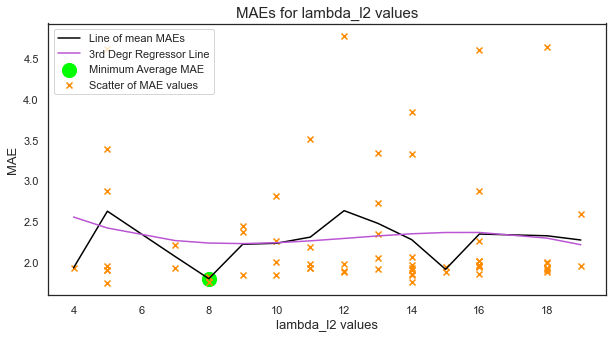

In [18]:
#array of the hyperparameters we tuned
arr_hypers = ["learning_rate","num_leaves","max_depth","bagging_fraction","bagging_freq","feature_fraction","lambda_l1","lambda_l2"]
arr_best_hypers = []
#iterate through each of these hypers
for hyper in tqdm(arr_hypers):

    df_max_depth = pd.DataFrame(columns = [hyper,"MAE"])

    #iterating through each column and randomly decide whether or not to pick it
    #iterating through every single models results
    for i in range(len(all_results)):
        # adding this models mae to the dict entry for this column
        df_max_depth.loc[i] = [all_results[i][1][1][hyper],all_results[i][0][1]]

    #sort in ascending order by the params values
    df_all = df_max_depth.sort_values(by=[hyper])
    # display(df_all)

    #grouping together by value and calculating mean
    grouped_df = df_all.groupby(hyper)
    mean_df = grouped_df.mean().reset_index()
    #display(mean_df)
    
    # the minimum point
    df_min = mean_df[mean_df['MAE']==mean_df['MAE'].min()]
    arr_best_hypers.append(df_min[hyper].values)
    display(df_min)

    #plotting the stats for this param 
    fig = plt.figure(figsize=(10,5))
    print(arr_best_hypers)
    
    plt.scatter(df_min[hyper], df_min.MAE, label="Minimum Average MAE", color="lime", marker="o",s=200)
    plt.plot(mean_df[hyper], mean_df.MAE, label="Line of mean MAEs", color="black") # line of means
    plt.scatter(df_all[hyper], df_all.MAE, label="Scatter of MAE values", color="darkorange", marker="x") # scatter of values
    plt.plot(np.unique(df_all[hyper]), 
             np.poly1d(np.polyfit(df_all[hyper], df_all.MAE, 3))
             (np.unique(df_all[hyper])), label="3rd Degr Regressor Line", color="mediumorchid") # line of best fit from a simple regressor

    plt.title(f"MAEs for {hyper} values", fontsize=15)
    plt.xlabel(f"{hyper} values", fontsize=13)
    plt.ylabel("MAE", fontsize=13)
    
    plt.legend()

    plt.show()
    fig.savefig(f"..\\Results\\Unclustered Random Search\\Plots\\{n}_scatter_{hyper}.png")
    plt.close(fig)
    del fig
    gc.collect()

### inspecting stats on all models TOE and MAE

In [19]:
#inspecting the min/max/mean of time of execution of the models we tested in random search
all_toes = []
all_maes = [] 

for i in range(len(all_results)):
    #getting the results for this model
    all_toes.append(all_results[i][0][0])
    all_maes.append(all_results[i][0][1])
    
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min time of execution = {color.END}{str(datetime.timedelta(seconds=round(min(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max time of execution = {color.END}{str(datetime.timedelta(seconds=round(max(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean time of execution = {color.END}{str(datetime.timedelta(seconds=round(np.mean(all_toes))))}")
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min MAE = {color.END}{min(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max MAE= {color.END}{max(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean MAE = {color.END}{np.mean(all_maes)}")


min time of execution = 0:00:17
max time of execution = 0:44:32
mean time of execution = 0:20:39

min MAE = 1.7452173623975176
max MAE= 4.7800872470200435
mean MAE = 2.3201282465575153


## Inspecting the results of the hyper parameter optimization

In [20]:
best_index = 0
best_mae = 999999

for i in range(len(all_results)):
    #getting the results for this model
    LGBM_TOE = all_results[i][0][0]
    LGBM_MAE = all_results[i][0][1]
    #displaying the results
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}skf-cv run {i}{color.END}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:{color.END} {str(datetime.timedelta(seconds=round(LGBM_TOE)))}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {LGBM_MAE}")
    print("")
    
    #keeping track of the best performing model
    if(LGBM_MAE<best_mae):
        best_mae=LGBM_MAE
        best_index = i
print("best model is at index",best_index,"with a MAE of",best_mae)

skf-cv run 0
Time of execution for skf-cv: 0:38:58
Mean absolute error between OOF preds and meter_reading on training set: 1.8607040921748639

skf-cv run 1
Time of execution for skf-cv: 0:00:17
Mean absolute error between OOF preds and meter_reading on training set: 4.7800872470200435

skf-cv run 2
Time of execution for skf-cv: 0:25:25
Mean absolute error between OOF preds and meter_reading on training set: 2.7260851289410333

skf-cv run 3
Time of execution for skf-cv: 0:00:44
Mean absolute error between OOF preds and meter_reading on training set: 4.613847044301183

skf-cv run 4
Time of execution for skf-cv: 0:30:27
Mean absolute error between OOF preds and meter_reading on training set: 1.9556754777873346

skf-cv run 5
Time of execution for skf-cv: 0:30:29
Mean absolute error between OOF preds and meter_reading on training set: 1.8810887902009288

skf-cv run 6
Time of execution for skf-cv: 0:28:10
Mean absolute error between OOF preds and meter_reading on training set: 1.85234938551

## Making predictions on best model

In [21]:
#making predictions based on the best performing model and displaying it's information
BEST_LGBM_MODELS = all_results[best_index][0][2] #getting the lgbm_models from the best index
BEST_LGBM_FORECASTS = df_preds.copy()
start_time = time.time() 

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(BEST_LGBM_MODELS)):
    pred_forecasts = BEST_LGBM_MODELS[i].predict(BEST_LGBM_FORECASTS[all_results[best_index][1][0]], num_iteration=BEST_LGBM_MODELS[i].best_iteration_) #predicting the unkown df_preds
    BEST_LGBM_FORECASTS[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
BEST_LGBM_FORECASTS["meter_reading"] = BEST_LGBM_FORECASTS.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0
execution_time = time.time() - start_time

## Inspecting information on best model

In [22]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}best model came from skf-cv run {best_index}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(all_results[best_index][0][0])))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for predictions: {color.END}{str(datetime.timedelta(seconds=round(execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Total time of execution: {color.END}{str(datetime.timedelta(seconds=round(all_results[best_index][0][0]+execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {all_results[best_index][0][1]}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}preds set with the next years forecasts for each meter{color.END}")
display(BEST_LGBM_FORECASTS[["meter_id","date","meter_reading"]])
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(all_results[best_index][1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(all_results[best_index][1][1])

best model came from skf-cv run 33
Evaluation and results
Time of execution for skf-cv:  0:32:48

Time of execution for predictions: 1:04:39

Total time of execution: 1:37:28

Mean absolute error between OOF preds and meter_reading on training set: 1.7452173623975176

preds set with the next years forecasts for each meter


,meter_id,date,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-01,6.272316
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-02,6.248647
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-03,5.902878
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-04,5.674856
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2018-01-05,5.827339
...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-27,20.822624
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-28,18.667341
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-29,17.444106
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2018-12-30,16.442387


Hyper-parameters

X_cols:

['meter_id_ord',
 'meter_id_0',
 'meter_id_1',
 'meter_id_2',
 'meter_id_3',
 'meter_id_4',
 'meter_id_5',
 'meter_id_6',
 'meter_id_7',
 'meter_id_8',
 'meter_id_9',
 'meter_id_10',
 'meter_id_11',
 'meter_id_12',
 'day_of_year_sin',
 'day_of_year_cos',
 'day_of_week',
 'month_ord',
 'month_sin',
 'month_cos',
 'is_weekend',
 'energy_cluster',
 'detached',
 'flat',
 'semi_detached',
 'terraced']
model params:  
{'bagging_fraction': 0.87,
 'bagging_freq': 18,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.93,
 'lambda_l1': 7,
 'lambda_l2': 5,
 'learning_rate': 0.034,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 958,
 'num_threads': -1,
 'seed': 1337}


## Saving the description of the best model

In [23]:
BEST_LGBM_FORECASTS.to_pickle(f"..\\Results\\Unclustered Random Search\\{n}_best_model_daily_forecasts.pkl")

In [24]:
import pickle

desc_disc = {
    "time_of_execution_skf-cv":str(datetime.timedelta(seconds=round(all_results[best_index][0][0]))),
    "time_of_execution_preds":str(datetime.timedelta(seconds=round(execution_time))),
    "time_of_execution_total":str(datetime.timedelta(seconds=round(all_results[best_index][0][0]+execution_time))),
    "MAE":all_results[best_index][0][1],
    "features":all_results[best_index][1][0],
    "params":all_results[best_index][1][1]
}

with open(f"..\\Results\\Unclustered Random Search\\{n}_best_model_desc.pkl", 'wb') as handle:
    pickle.dump(desc_disc, handle, protocol=pickle.HIGHEST_PROTOCOL)

pprint(desc_disc)
    
# verifying it saved correctly and can be loaded back
with open(f"..\\Results\\Unclustered Random Search\\{n}_best_model_desc.pkl", 'rb') as handle:
    desc_disc_loaded = pickle.load(handle)
print(desc_disc == desc_disc_loaded)

{'MAE': 1.7452173623975176,
 'features': ['meter_id_ord',
              'meter_id_0',
              'meter_id_1',
              'meter_id_2',
              'meter_id_3',
              'meter_id_4',
              'meter_id_5',
              'meter_id_6',
              'meter_id_7',
              'meter_id_8',
              'meter_id_9',
              'meter_id_10',
              'meter_id_11',
              'meter_id_12',
              'day_of_year_sin',
              'day_of_year_cos',
              'day_of_week',
              'month_ord',
              'month_sin',
              'month_cos',
              'is_weekend',
              'energy_cluster',
              'detached',
              'flat',
              'semi_detached',
              'terraced'],
 'params': {'bagging_fraction': 0.87,
            'bagging_freq': 18,
            'boosting_type': 'gbdt',
            'feature_fraction': 0.93,
            'lambda_l1': 7,
            'lambda_l2': 5,
            'learning_rate': 0.0

# Converting into monthly forecasts

In [25]:
#restructuring into the original multiple time series format
#aggregating up the total sum of the months predictions
df_monthly_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id", "month_ord"])["meter_reading"].sum().unstack()

#rename ordinal encoded month with its corresponding name
df_monthly_forecasts.rename(columns={1:"Jan", 2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}, inplace=True)
#resetting the index 
df_monthly_forecasts.reset_index(inplace=True)
df_monthly_forecasts.index.name = None # removing index column
df_monthly_forecasts.columns.name = None # removing columns name

display(df_monthly_forecasts)

,meter_id,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,140.076202,121.386040,115.584001,110.417893,117.472436,118.866503,120.631991,123.039800,122.294225,125.392678,101.400632,112.749588
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,708.822999,647.489192,607.768041,506.191614,471.714354,418.376209,400.899415,425.185674,490.196963,546.967092,609.272266,645.815762
2,0x0019979ee12c59accd24d1c83291528ced1bb734,268.749525,216.001941,221.566506,211.555764,204.385542,195.723127,190.929670,202.216226,201.247863,206.033785,209.574383,232.753497
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,178.079327,147.515469,144.811871,125.925252,135.157143,131.397722,126.932926,132.037112,131.982618,147.036376,147.002375,158.611314
4,0x005958406351bb29580475df698b5f1070096397,370.115539,339.639398,363.687345,304.136435,286.177533,275.564229,263.765584,273.848206,282.312514,328.247717,351.269744,385.790969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,190.844483,157.842626,160.176891,141.666167,140.397222,134.712810,134.281379,136.143137,134.157014,149.893899,157.188488,170.010028
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,682.212575,625.338724,722.168153,680.442572,590.392360,461.616934,458.917164,469.906785,519.583966,577.237958,573.983443,620.560574
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,520.974368,429.663186,415.340161,376.216333,347.595125,268.581470,276.432751,276.324798,293.014059,340.690851,425.303035,519.421946
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,417.534496,374.876722,340.471390,368.929872,219.482992,199.859985,192.320429,201.283192,225.413744,270.974364,311.046248,390.204275


## Saving these monthly predictions to be submitted to competition
* Saving predictions ready to be submitted so I can get the MAE on the test set

In [26]:
df_monthly_forecasts.to_csv(f"..\\Results\\Unclustered Random Search\\{n}_best_model_monthly_forecasts.csv", index=False, header=True)

# Plotting these monthly forecasts
## Renaming months to dates for plotting

In [27]:
df_monthly_forecasts.rename(columns={"Jan":"2018-01", "Feb":"2018-02","Mar":"2018-03","Apr":"2018-04","May":"2018-05","Jun":"2018-06","Jul":"2018-07","Aug":"2018-08","Sep":"2018-09","Oct":"2018-10","Nov":"2018-11","Dec":"2018-12"}, inplace=True)
df_monthly_forecasts

,meter_id,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,140.076202,121.386040,115.584001,110.417893,117.472436,118.866503,120.631991,123.039800,122.294225,125.392678,101.400632,112.749588
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,708.822999,647.489192,607.768041,506.191614,471.714354,418.376209,400.899415,425.185674,490.196963,546.967092,609.272266,645.815762
2,0x0019979ee12c59accd24d1c83291528ced1bb734,268.749525,216.001941,221.566506,211.555764,204.385542,195.723127,190.929670,202.216226,201.247863,206.033785,209.574383,232.753497
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,178.079327,147.515469,144.811871,125.925252,135.157143,131.397722,126.932926,132.037112,131.982618,147.036376,147.002375,158.611314
4,0x005958406351bb29580475df698b5f1070096397,370.115539,339.639398,363.687345,304.136435,286.177533,275.564229,263.765584,273.848206,282.312514,328.247717,351.269744,385.790969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,190.844483,157.842626,160.176891,141.666167,140.397222,134.712810,134.281379,136.143137,134.157014,149.893899,157.188488,170.010028
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,682.212575,625.338724,722.168153,680.442572,590.392360,461.616934,458.917164,469.906785,519.583966,577.237958,573.983443,620.560574
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,520.974368,429.663186,415.340161,376.216333,347.595125,268.581470,276.432751,276.324798,293.014059,340.690851,425.303035,519.421946
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,417.534496,374.876722,340.471390,368.929872,219.482992,199.859985,192.320429,201.283192,225.413744,270.974364,311.046248,390.204275


## Restructuring forecasts into daily predictions to plot on top of monthly preds

In [28]:
#daily forecasts to plot on top of monthly
df_daily_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id","date"])["meter_reading"].sum().unstack()

#resetting the index 
df_daily_forecasts.reset_index(inplace=True)
df_daily_forecasts.index.name = None # removing index column
df_daily_forecasts.columns.name = None # removing columns name

df_daily_forecasts

,meter_id,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00,2018-01-06 00:00:00,2018-01-07 00:00:00,2018-01-08 00:00:00,2018-01-09 00:00:00,...,2018-12-22 00:00:00,2018-12-23 00:00:00,2018-12-24 00:00:00,2018-12-25 00:00:00,2018-12-26 00:00:00,2018-12-27 00:00:00,2018-12-28 00:00:00,2018-12-29 00:00:00,2018-12-30 00:00:00,2018-12-31 00:00:00
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,4.945189,4.671512,4.202454,4.539602,4.819104,5.089369,5.016525,4.539180,4.521331,...,3.801700,3.445925,3.367698,3.147101,3.337852,3.514143,3.790649,3.982846,3.580470,3.788609
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,19.623844,21.837937,22.354535,21.008771,22.279389,23.766824,23.848451,22.987407,23.378299,...,23.890691,22.807691,20.327068,18.709093,20.748673,20.908697,19.899464,18.028337,17.249992,19.189120
2,0x0019979ee12c59accd24d1c83291528ced1bb734,8.997209,9.666831,9.254574,9.194762,9.060959,9.357708,8.587203,8.564831,8.513424,...,7.802671,7.763239,7.766354,7.700855,7.749479,8.196402,7.920304,7.901098,7.850499,7.794522
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,6.399480,6.284248,5.639768,5.922533,5.984615,6.441480,6.351635,5.596270,5.593457,...,5.245611,4.729854,3.995926,4.515604,4.571921,4.660590,5.041583,5.928230,5.400446,5.183413
4,0x005958406351bb29580475df698b5f1070096397,12.375379,12.571615,11.675592,11.453176,11.203785,12.025199,12.118260,10.446923,11.207761,...,13.399066,12.423272,10.480623,9.916612,11.578544,12.347478,12.732681,12.338315,12.840833,12.502982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,6.402080,6.420091,6.106932,6.310180,6.683443,6.495480,6.603492,6.562441,6.786928,...,5.439414,5.346363,5.220013,5.267605,5.211439,5.541729,5.318880,5.544760,5.680314,5.536648
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,22.970346,23.678414,22.933031,22.371048,21.327872,21.716549,21.557777,21.051980,21.743865,...,18.757392,18.527690,18.714130,19.147095,20.243633,21.488383,21.010725,20.653832,19.594637,21.904445
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,19.551406,18.768429,17.462476,16.651114,16.455308,16.637636,17.501346,17.461901,15.833297,...,15.356468,15.806989,16.944736,15.535246,16.421750,17.686223,16.880615,15.766382,16.168799,18.313642
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,13.051071,13.454416,13.655114,13.155370,13.164218,13.342574,13.525373,13.555292,12.970917,...,12.524586,12.792055,13.562626,12.205732,12.809843,12.957406,12.599051,12.289674,12.191658,13.265567


## loading training data and aggregating into months

In [29]:
#loading the training data
print("training data")
df_train_daily = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl").fillna(0)

#aggregating up into months
meter_id=df_monthly_forecasts["meter_id"]
df_train_monthly = pd.DataFrame(columns=["meter_id"])
df_train_monthly["meter_id"] = meter_id


#for each month in the range of dates
resample_size="M"
for new_sample in tqdm(pd.date_range(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31), freq = resample_size),position=0):

    #get this columns name as a string
    columnName = str(new_sample.date())[:7]
    #get all columns that relate to this new sample
    columns = [i for i in df_train_daily.columns.values[1:] if i.startswith(columnName)]

    #sum these up into a value for the new sample size
    df_train_monthly[columnName] = df_train_daily[columns].sum(axis=1)

display(df_train_daily)
display(df_train_monthly)

training data


  0%|          | 0/12 [00:00<?, ?it/s]

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,4.030,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,13.101,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,10.201,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,14.833,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,39.440,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,2.317,2.301,2.352,2.516,2.229,2.354,2.397,2.397,2.269,...,9.390,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,14.437,16.274,7.031,17.018,17.603,15.005,8.987,8.490,10.136,...,4.141,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.824,7.517,5.398,6.788,7.360,6.898,7.321,8.042,8.207,...,6.767,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148
3246,0x47218b46abb2fcaade487a211911406dc6e13730,23.965,28.689,27.664,29.229,29.548,27.909,26.923,21.277,23.452,...,20.747,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201


,meter_id,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,128.39450
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,553.18400
2,0x0019979ee12c59accd24d1c83291528ced1bb734,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,368.90957
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,534.84650
4,0x005958406351bb29580475df698b5f1070096397,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,946.06400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,72.7050,63.245,68.4335,66.6265,69.0480,100.430,177.1735,177.4100,216.7245,279.164500,351.481000,312.08800
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,371.4390,269.691,179.3430,141.6590,138.4835,122.910,164.2285,100.9610,118.0520,123.135500,187.140000,186.88400
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,209.8065,169.858,184.0130,166.7280,134.1760,169.489,157.5775,165.9640,177.0105,185.701833,192.288667,200.61950
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,845.6630,608.449,588.7765,503.3050,291.1320,177.605,183.5345,182.0350,244.2255,371.458333,695.878667,858.83950


## Plotting the predictions against the training data

  0%|          | 0/3248 [00:00<?, ?it/s]

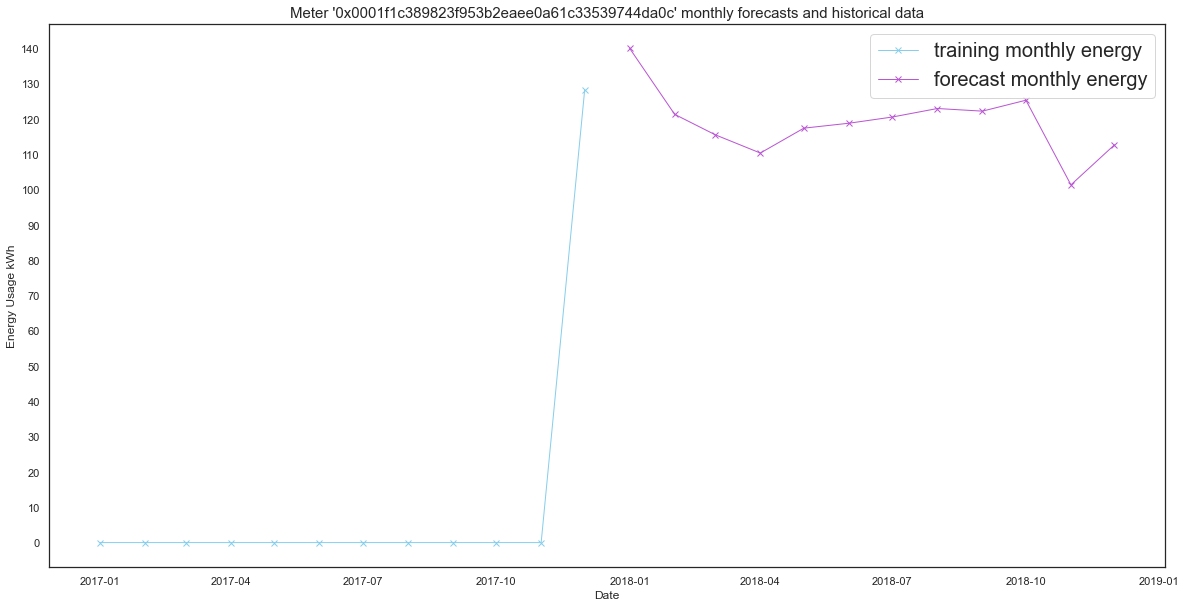

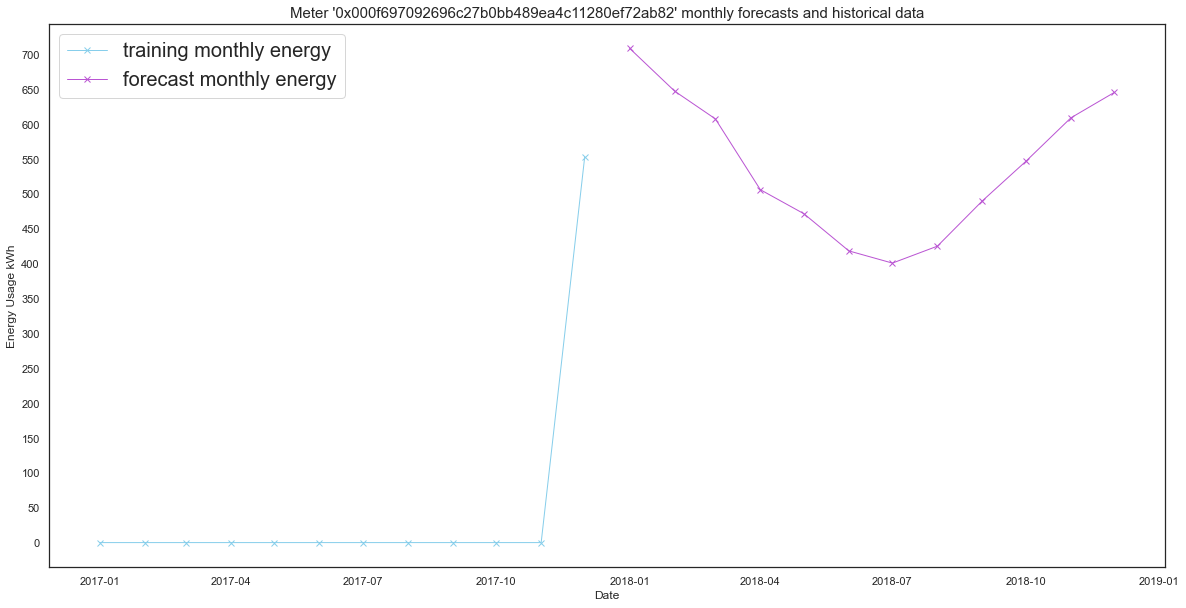

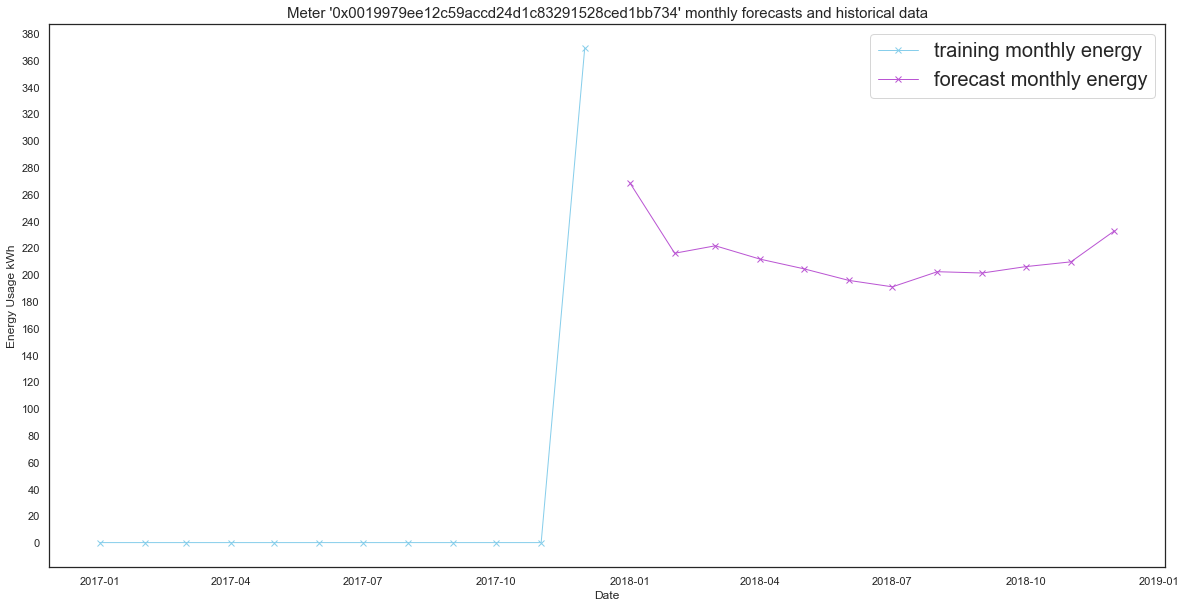

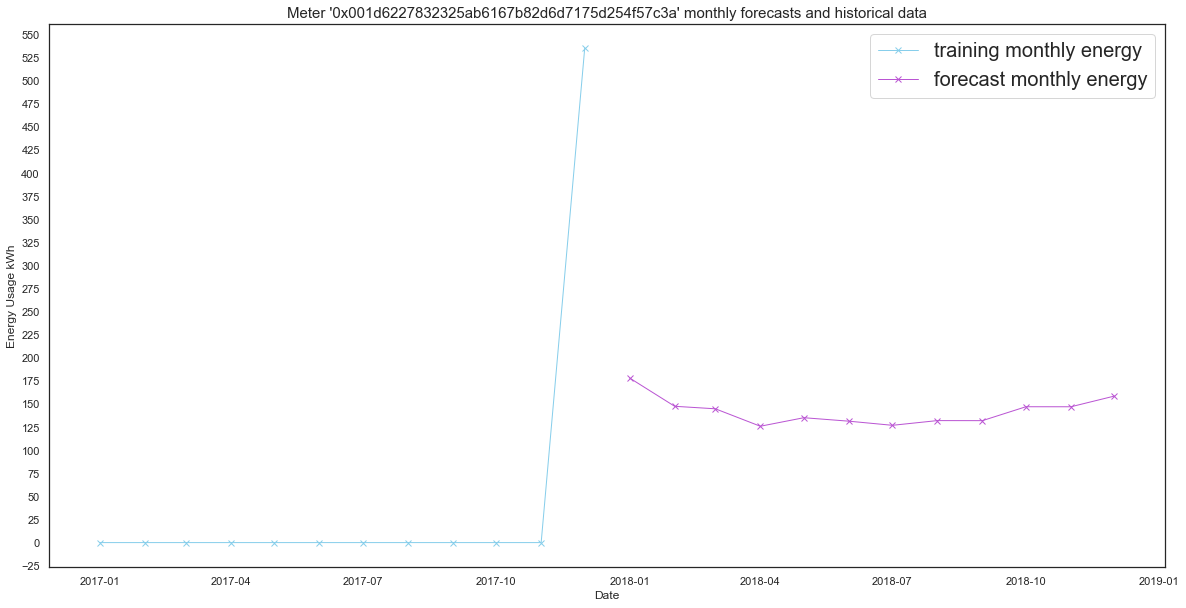

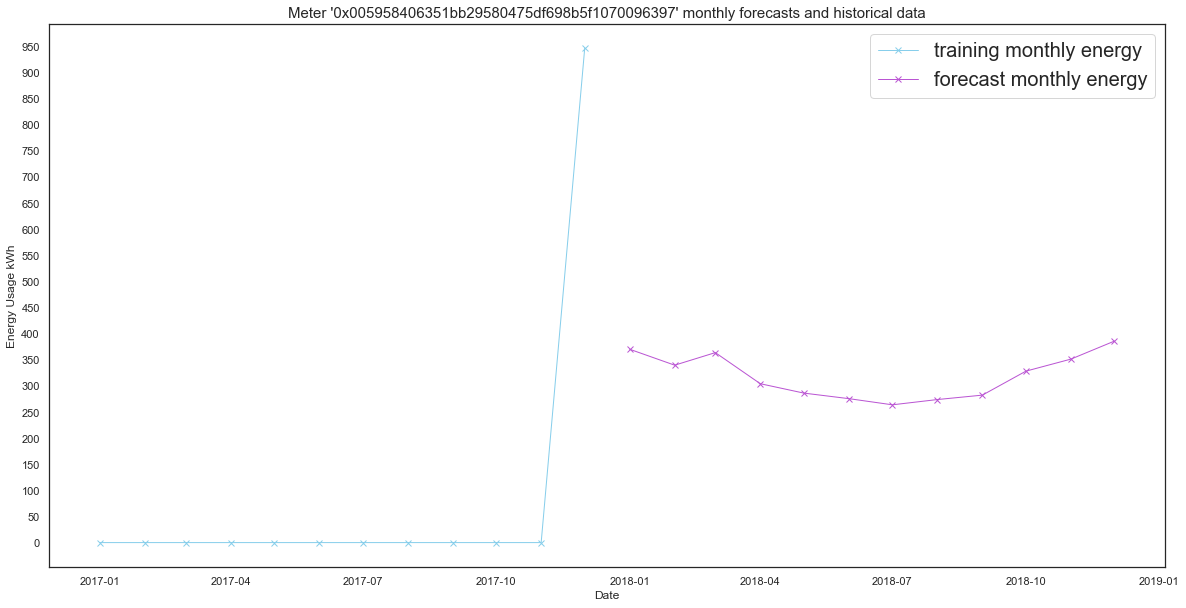

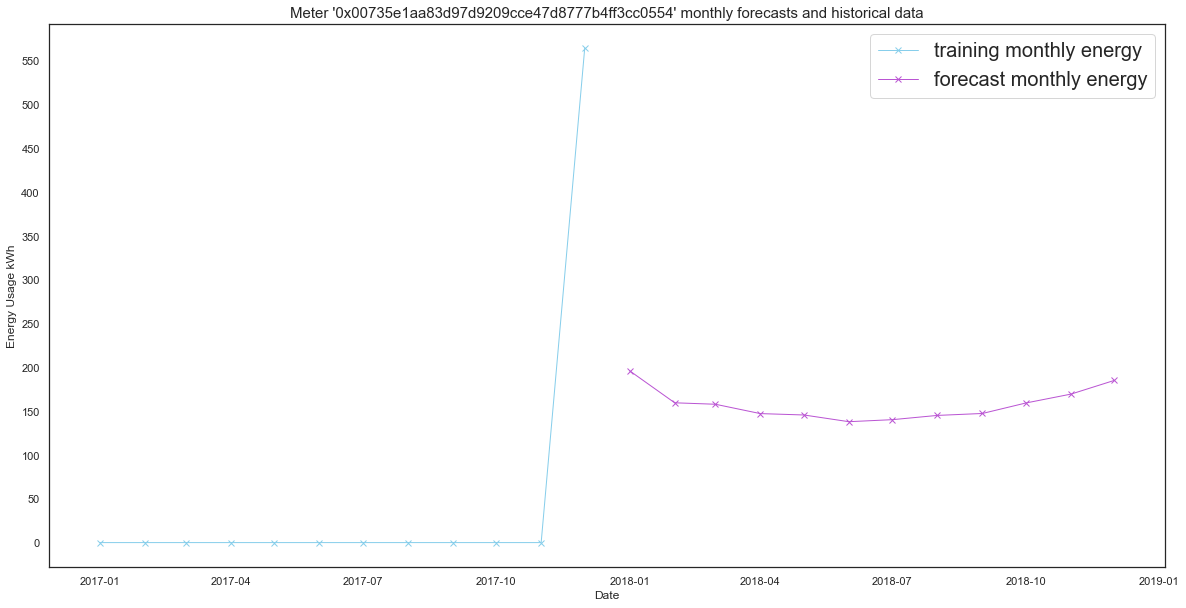

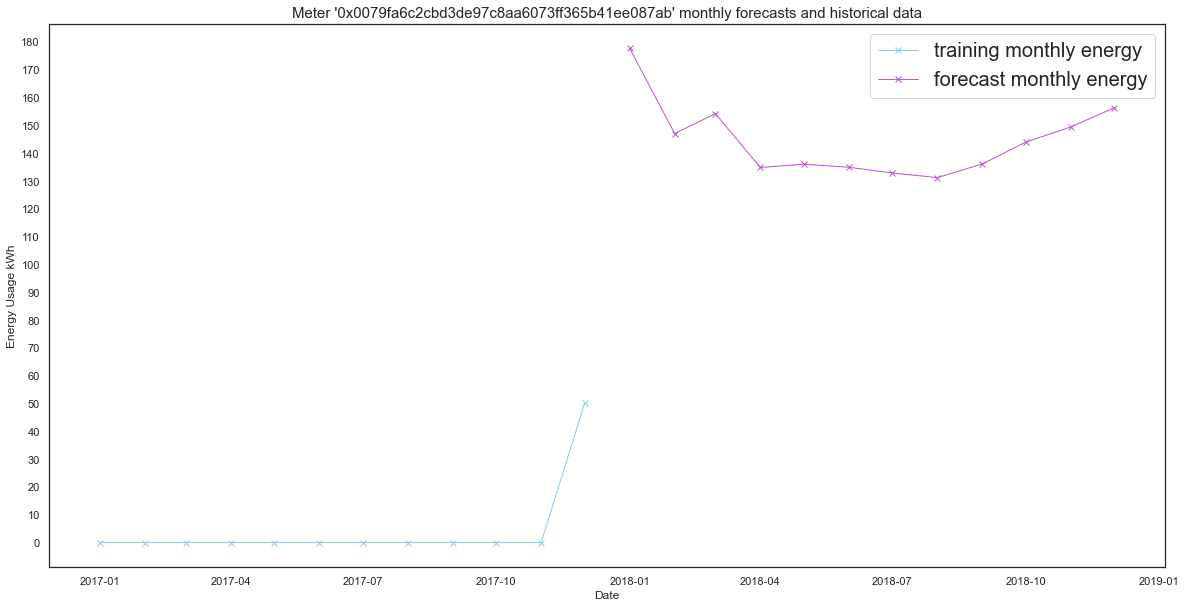

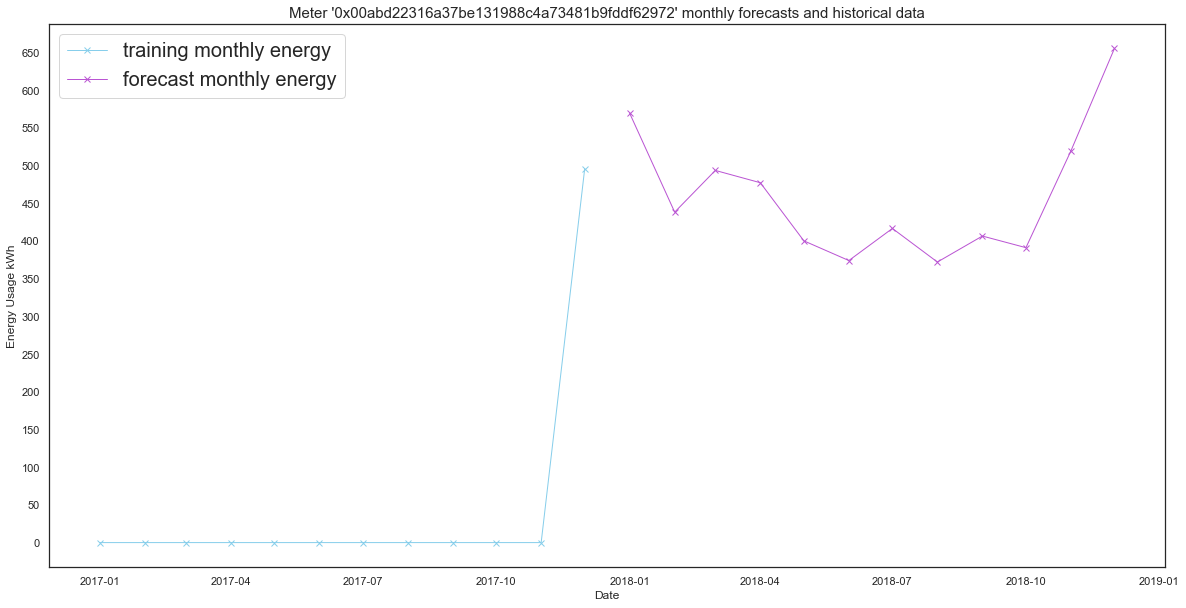

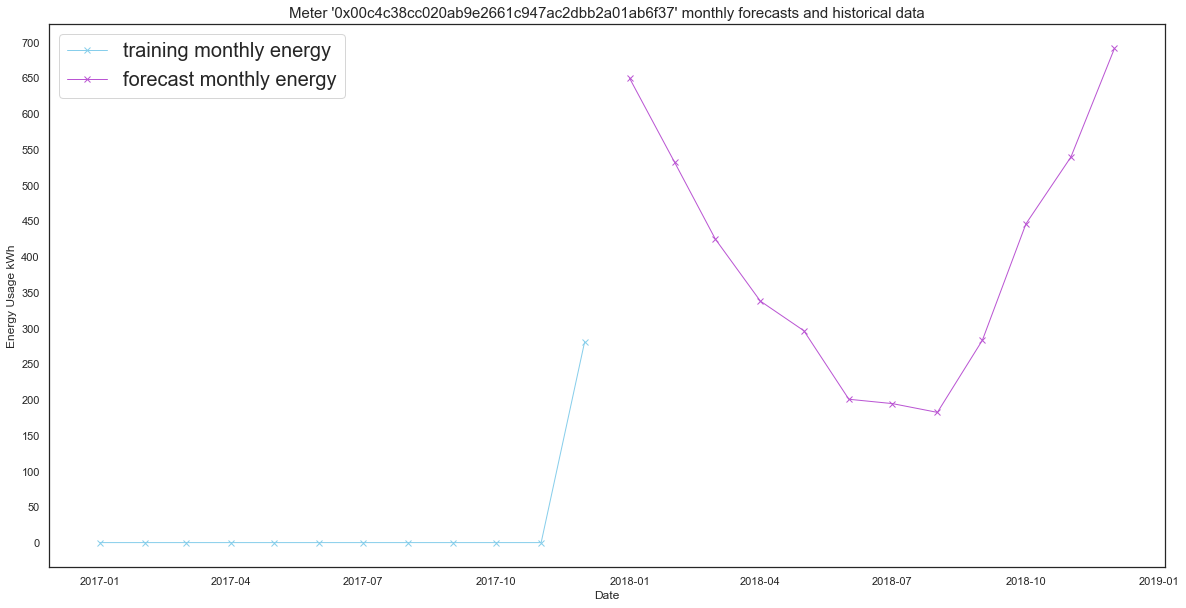

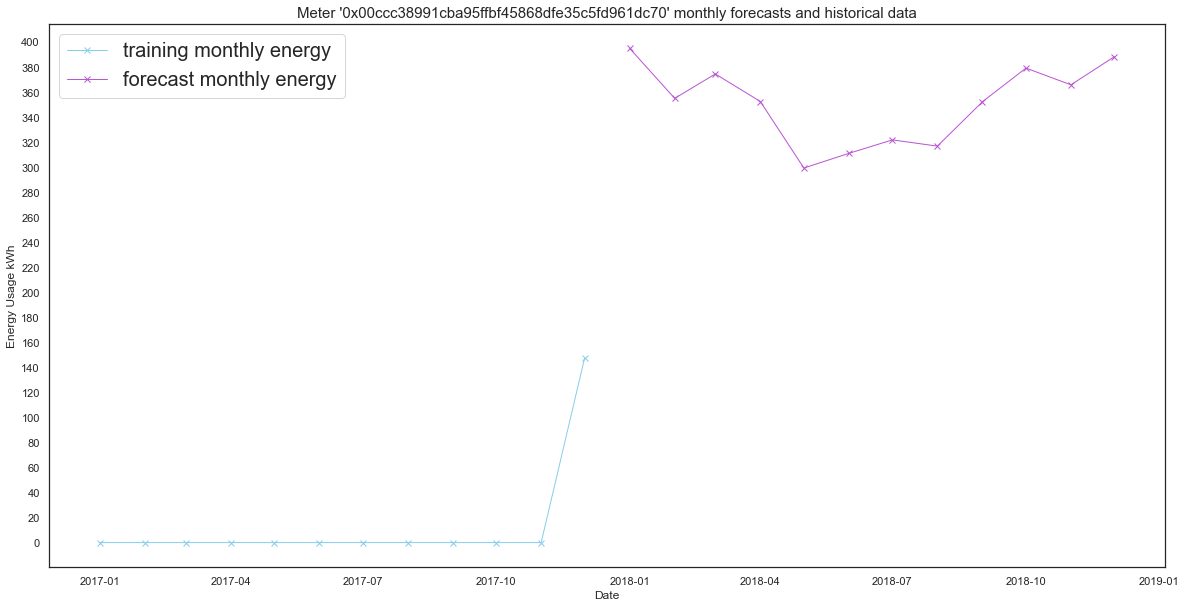

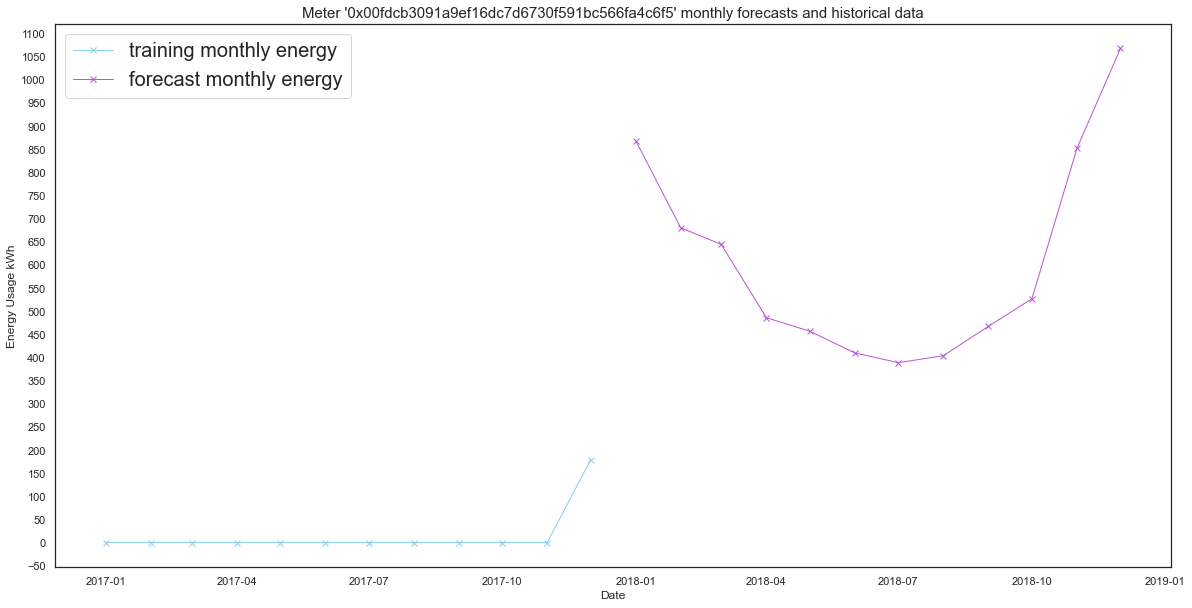

In [30]:
num_plots = 10
for pid in tqdm(range(0,3248)):
    if pid>num_plots:
        break
        
    #getting the row corresponding to this meter_id
    meter_id = df_daily_forecasts.iloc[pid,0]
    this_train_month = df_train_monthly.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_preds_month = df_monthly_forecasts.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    
    #converting index to datetime for ease of plots key
    this_train_month.index=pd.to_datetime(this_train_month.index)
    this_preds_month.index=pd.to_datetime(this_preds_month.index)
    
    #creating figure
    fig = plt.figure(figsize=(20,10))
    
    #plotting the monthly predictions
    plt.title("Meter '"+str(meter_id)+"' monthly forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_month, label="training monthly energy", lw=1,color="skyblue", marker="x")
    plt.plot(this_preds_month, label="forecast monthly energy", lw=1,color="mediumorchid", marker="x")
    
    #annotations
    plt.legend(fontsize=20)
    plt.locator_params(nbins=24)
    
    plt.show()
    fig.savefig(f"..\\Results\\Unclustered Random Search\\Plots\\forecasts\\{n}_forecasts_{pid}_{meter_id}.png")
    
    fig.clf()
    fig.clear()
    plt.close()
    del fig, this_train_month, this_preds_month
    gc.collect()

# Training a model based on the main effects
* Running on the hyper params determined by main effects (setting that gave the lowest mean result)

In [31]:
# treating columns like main effects: accepting those whose mean error with the column is better than that without the column
main_columm_types = []
i=0
for key in possible_columns.keys():
    print(key,column_means[i]<columnless_means[i])
    main_columm_types.append(key)
    i+=1 
print(main_columm_types)

meter_id_ord True
meter_id_binary True
day_of_year_cyclic True
day_of_week True
day_of_month True
month_ord True
month_cyclic True
is_weekend True
energy_cluster True
num_bedrooms False
dwelling_type_ord True
dwelling_type_onehot True
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'day_of_month', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'dwelling_type_onehot']


In [32]:
#inspecting the stored best values for each hyper as determined by the main effects plot
#(value which resulted in the lowest average MAE on the val set)
print(arr_hypers)
print(arr_best_hypers) 

['learning_rate', 'num_leaves', 'max_depth', 'bagging_fraction', 'bagging_freq', 'feature_fraction', 'lambda_l1', 'lambda_l2']
[array([0.089]), array([958.]), array([10.]), array([0.89]), array([12.]), array([0.74]), array([14.]), array([8.])]


In [33]:
start_time = time.time()
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Running with main effects determined configuration{color.END}")

print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Using the features{color.END}")
X_cols =[]

for key in main_columm_types:
    X_cols+=(possible_columns[key])
this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
print(X_cols)

print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Using the main effects hyper parameters{color.END}")
this_params = params.copy()
this_params["learning_rate"] = arr_best_hypers[0][0]
this_params["max_depth"] = int(arr_best_hypers[2][0])
this_params["num_leaves"] = int(arr_best_hypers[1][0])
this_params["bagging_fraction"] = arr_best_hypers[3][0]
this_params["bagging_freq"] = int(arr_best_hypers[4][0])
this_params["feature_fraction"] = arr_best_hypers[5][0]
this_params["lambda_l1"] = int(arr_best_hypers[6][0])
this_params["lambda_l2"] = int(arr_best_hypers[7][0])
pprint(this_params)

#train the model with this hyper param config and store it's results
results=((run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params),(X_cols,this_params)))
print("\n\n\n")
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Trained the model in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n")

Running with main effects determined configuration
Using the features
['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'day_of_month', 'month_ord', 'month_sin', 'month_cos', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
Using the main effects hyper parameters
{'bagging_fraction': 0.89,
 'bagging_freq': 12,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.74,
 'lambda_l1': 14,
 'lambda_l2': 8,
 'learning_rate': 0.089,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 958,
 'num_threads': -1,
 'seed': 1337}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.74, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.74
[LightGBM] [Warning] lambda_l1 is

# Forecasting from the main effects model

In [34]:
#making predictions based on the best performing model and displaying it's information
main_effects_models = results[0][2] #getting the lgbm_models from the best index
main_effects_forecasts = df_preds.copy()

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(main_effects_models)):
    pred_forecasts = main_effects_models[i].predict(main_effects_forecasts[results[1][0]], num_iteration=main_effects_models[i].best_iteration_) #predicting the unkown df_preds
    main_effects_forecasts[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
main_effects_forecasts["meter_reading"] = main_effects_forecasts.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0

display(main_effects_forecasts)

,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,is_weekend,energy_cluster,num_bedrooms,dwelling_type,dwelling_type_ord,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,4.641252
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,5.546318
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,4.810411
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,5.104254
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,5.152136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,18.431218
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,17.345593
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,18.368336
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,18.617932


# Comparing the val error of the main effects vs the best from random search
## Random search summary

In [35]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Random Search best model came from skf-cv run {best_index}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {all_results[best_index][0][1]}\n")
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(all_results[best_index][1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(all_results[best_index][1][1])

Random Search best model came from skf-cv run 33
Evaluation and results
Mean absolute error between OOF preds and meter_reading on training set: 1.7452173623975176

Hyper-parameters

X_cols:

['meter_id_ord',
 'meter_id_0',
 'meter_id_1',
 'meter_id_2',
 'meter_id_3',
 'meter_id_4',
 'meter_id_5',
 'meter_id_6',
 'meter_id_7',
 'meter_id_8',
 'meter_id_9',
 'meter_id_10',
 'meter_id_11',
 'meter_id_12',
 'day_of_year_sin',
 'day_of_year_cos',
 'day_of_week',
 'month_ord',
 'month_sin',
 'month_cos',
 'is_weekend',
 'energy_cluster',
 'detached',
 'flat',
 'semi_detached',
 'terraced']
model params:  
{'bagging_fraction': 0.87,
 'bagging_freq': 18,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.93,
 'lambda_l1': 7,
 'lambda_l2': 5,
 'learning_rate': 0.034,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 958,
 'num_threads': -1,
 'seed': 1337}


## Main effects based model summary

In [36]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Main effects model based on results of RS {best_index}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {results[0][1]}\n")
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(results[1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(results[1][1])

Main effects model based on results of RS 33
Evaluation and results
Mean absolute error between OOF preds and meter_reading on training set: 1.892412442853182

Hyper-parameters

X_cols:

['meter_id_ord',
 'meter_id_0',
 'meter_id_1',
 'meter_id_2',
 'meter_id_3',
 'meter_id_4',
 'meter_id_5',
 'meter_id_6',
 'meter_id_7',
 'meter_id_8',
 'meter_id_9',
 'meter_id_10',
 'meter_id_11',
 'meter_id_12',
 'day_of_year_sin',
 'day_of_year_cos',
 'day_of_week',
 'day_of_month',
 'month_ord',
 'month_sin',
 'month_cos',
 'is_weekend',
 'energy_cluster',
 'num_bedrooms',
 'dwelling_type_ord',
 'detached',
 'flat',
 'semi_detached',
 'terraced']
model params:  
{'bagging_fraction': 0.89,
 'bagging_freq': 12,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.74,
 'lambda_l1': 14,
 'lambda_l2': 8,
 'learning_rate': 0.089,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 958,
 'num_threads': -1,
 'seed': 1337}


#### Conclusion
* It is clear the model found via random search vastly outperforms that made from the main effects plots of the random search hyper parameters in terms of the validation error calculated via the OOF predictions from the skf-cv


# Save the main effects description
* THe hypers for the main effects and the best of random search will be used as initial population in evolution algorithm

In [37]:
import pickle

a = {'hello': 'world'}
desc_disc = {
    "MAE":results[0][1],
    "features":results[1][0],
    "params":results[1][1]
}

with open(f"..\\Results\\Unclustered Random Search\\{n}_main_effects_desc.pkl", 'wb') as handle:
    pickle.dump(desc_disc, handle, protocol=pickle.HIGHEST_PROTOCOL)

pprint(desc_disc)
    
# verifying it saved correctly and can be loaded back
with open(f"..\\Results\\Unclustered Random Search\\{n}_main_effects_desc.pkl", 'rb') as handle:
    desc_disc_loaded = pickle.load(handle)
print(desc_disc == desc_disc_loaded)

{'MAE': 1.892412442853182,
 'features': ['meter_id_ord',
              'meter_id_0',
              'meter_id_1',
              'meter_id_2',
              'meter_id_3',
              'meter_id_4',
              'meter_id_5',
              'meter_id_6',
              'meter_id_7',
              'meter_id_8',
              'meter_id_9',
              'meter_id_10',
              'meter_id_11',
              'meter_id_12',
              'day_of_year_sin',
              'day_of_year_cos',
              'day_of_week',
              'day_of_month',
              'month_ord',
              'month_sin',
              'month_cos',
              'is_weekend',
              'energy_cluster',
              'num_bedrooms',
              'dwelling_type_ord',
              'detached',
              'flat',
              'semi_detached',
              'terraced'],
 'params': {'bagging_fraction': 0.89,
            'bagging_freq': 12,
            'boosting_type': 'gbdt',
            'feature_fraction': 

# Formatting the main effects forecasts and saving them

# Converting into monthly forecasts

In [38]:
#restructuring into the original multiple time series format
#aggregating up the total sum of the months predictions
df_monthly_forecasts = main_effects_forecasts.groupby(["meter_id", "month_ord"])["meter_reading"].sum().unstack()

#rename ordinal encoded month with its corresponding name
df_monthly_forecasts.rename(columns={1:"Jan", 2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}, inplace=True)
#resetting the index 
df_monthly_forecasts.reset_index(inplace=True)
df_monthly_forecasts.index.name = None # removing index column
df_monthly_forecasts.columns.name = None # removing columns name

display(df_monthly_forecasts)

,meter_id,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,154.411528,120.600545,115.637964,102.957708,102.586910,106.604517,108.840273,120.443987,120.309983,119.277632,94.658649,116.442144
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,693.369387,582.036875,558.215255,499.993999,469.819168,438.026977,428.626745,423.308814,483.347645,545.373188,600.995727,658.723895
2,0x0019979ee12c59accd24d1c83291528ced1bb734,300.523138,248.169151,211.570313,199.711511,208.819621,202.183906,205.005624,213.461769,204.577546,201.709091,206.014254,229.540299
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,178.870341,149.135596,148.981252,134.799171,127.601236,134.081647,129.564466,124.446507,128.252365,143.821979,144.388000,156.403375
4,0x005958406351bb29580475df698b5f1070096397,359.191469,351.235431,374.022837,312.842694,293.713432,321.971612,318.605119,309.130270,333.731476,348.257094,354.758305,382.998151
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,289.528417,201.471999,167.580336,150.848617,136.362877,126.280921,131.634526,128.481190,130.126180,147.017984,155.414918,174.437558
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,726.552450,657.764169,711.943455,690.208881,600.746592,465.428124,454.540419,471.026424,504.471281,558.747330,564.727556,628.357364
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,552.962693,457.782671,426.008009,370.803022,348.178068,260.645803,274.746684,272.790717,292.812657,338.620320,436.004933,518.041583
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,374.333006,377.531598,339.162848,380.594715,212.525323,195.606252,194.619420,200.204123,216.215672,260.503703,310.896329,386.201841


## Saving these monthly predictions to be submitted to competition
* Saving predictions ready to be submitted so I can get the MAE on the test set

In [39]:
df_monthly_forecasts.to_csv(f"..\\Results\\Unclustered Random Search\\{n}_main_effects_monthly_forecasts.csv", index=False, header=True)

# Plotting these monthly forecasts
## Renaming months to dates for plotting

In [40]:
df_monthly_forecasts.rename(columns={"Jan":"2018-01", "Feb":"2018-02","Mar":"2018-03","Apr":"2018-04","May":"2018-05","Jun":"2018-06","Jul":"2018-07","Aug":"2018-08","Sep":"2018-09","Oct":"2018-10","Nov":"2018-11","Dec":"2018-12"}, inplace=True)
df_monthly_forecasts

,meter_id,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,154.411528,120.600545,115.637964,102.957708,102.586910,106.604517,108.840273,120.443987,120.309983,119.277632,94.658649,116.442144
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,693.369387,582.036875,558.215255,499.993999,469.819168,438.026977,428.626745,423.308814,483.347645,545.373188,600.995727,658.723895
2,0x0019979ee12c59accd24d1c83291528ced1bb734,300.523138,248.169151,211.570313,199.711511,208.819621,202.183906,205.005624,213.461769,204.577546,201.709091,206.014254,229.540299
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,178.870341,149.135596,148.981252,134.799171,127.601236,134.081647,129.564466,124.446507,128.252365,143.821979,144.388000,156.403375
4,0x005958406351bb29580475df698b5f1070096397,359.191469,351.235431,374.022837,312.842694,293.713432,321.971612,318.605119,309.130270,333.731476,348.257094,354.758305,382.998151
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,289.528417,201.471999,167.580336,150.848617,136.362877,126.280921,131.634526,128.481190,130.126180,147.017984,155.414918,174.437558
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,726.552450,657.764169,711.943455,690.208881,600.746592,465.428124,454.540419,471.026424,504.471281,558.747330,564.727556,628.357364
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,552.962693,457.782671,426.008009,370.803022,348.178068,260.645803,274.746684,272.790717,292.812657,338.620320,436.004933,518.041583
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,374.333006,377.531598,339.162848,380.594715,212.525323,195.606252,194.619420,200.204123,216.215672,260.503703,310.896329,386.201841


## Restructuring forecasts into daily predictions to plot on top of monthly preds

In [41]:
#daily forecasts to plot on top of monthly
df_daily_forecasts = main_effects_forecasts.groupby(["meter_id","date"])["meter_reading"].sum().unstack()

#resetting the index 
df_daily_forecasts.reset_index(inplace=True)
df_daily_forecasts.index.name = None # removing index column
df_daily_forecasts.columns.name = None # removing columns name

df_daily_forecasts

,meter_id,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00,2018-01-06 00:00:00,2018-01-07 00:00:00,2018-01-08 00:00:00,2018-01-09 00:00:00,...,2018-12-22 00:00:00,2018-12-23 00:00:00,2018-12-24 00:00:00,2018-12-25 00:00:00,2018-12-26 00:00:00,2018-12-27 00:00:00,2018-12-28 00:00:00,2018-12-29 00:00:00,2018-12-30 00:00:00,2018-12-31 00:00:00
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,6.477026,6.227475,4.896616,5.577098,5.034733,5.800149,5.447873,4.996553,4.799607,...,4.125546,3.969797,3.187582,3.234906,3.242964,3.769561,4.333379,4.621081,4.942487,3.932668
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,20.802079,21.614200,24.286580,21.571068,20.984749,23.669268,24.785302,23.415987,23.707915,...,22.407486,22.376004,22.022831,19.488780,19.864254,20.937254,21.398556,20.519401,18.025089,18.370453
2,0x0019979ee12c59accd24d1c83291528ced1bb734,10.107893,10.237977,10.060315,9.282718,9.261190,9.726666,10.211312,9.315841,9.581906,...,7.337461,8.148399,8.046434,7.775358,7.545525,8.268839,8.358077,7.894882,7.790054,7.696833
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,6.089361,6.263276,5.881140,5.729217,6.123006,5.992173,6.583986,5.557945,6.024888,...,4.974735,4.817262,3.695073,4.088530,4.556088,4.451678,5.473678,6.099720,5.824748,4.526515
4,0x005958406351bb29580475df698b5f1070096397,12.448823,10.635522,11.320571,10.521139,10.223291,11.306898,12.229157,11.440140,10.435180,...,13.356385,12.940349,11.935096,9.991595,9.500515,11.423049,12.120167,12.926697,12.712795,11.275001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,9.887940,9.931141,9.259554,9.479714,9.696763,10.856747,9.899614,9.705688,10.408528,...,5.877852,6.256930,5.311314,5.863840,5.507414,5.558381,6.008170,6.219210,6.333877,5.916297
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,24.788408,25.783390,24.361111,22.790656,23.310915,22.700579,22.054497,23.212959,23.061266,...,18.407100,18.490334,18.513669,18.890527,19.585149,21.480431,21.417647,21.491346,21.306360,20.721411
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,19.418011,19.419850,19.560431,16.341557,17.174468,16.556719,17.699605,19.743212,16.007557,...,13.753691,15.444312,16.348480,13.914723,14.729712,15.901474,16.509730,15.120865,15.427070,17.534082
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,11.884761,12.408934,11.856322,12.807083,11.877439,13.019965,11.935531,12.852468,11.623961,...,12.232329,12.031042,13.482067,13.077993,12.128914,13.313038,13.053193,12.734108,11.028093,12.387639


## loading training data and aggregating into months

In [42]:
#loading the training data
print("training data")
df_train_daily = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl").fillna(0)

#aggregating up into months
meter_id=df_monthly_forecasts["meter_id"]
df_train_monthly = pd.DataFrame(columns=["meter_id"])
df_train_monthly["meter_id"] = meter_id


#for each month in the range of dates
resample_size="M"
for new_sample in tqdm(pd.date_range(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31), freq = resample_size),position=0):

    #get this columns name as a string
    columnName = str(new_sample.date())[:7]
    #get all columns that relate to this new sample
    columns = [i for i in df_train_daily.columns.values[1:] if i.startswith(columnName)]

    #sum these up into a value for the new sample size
    df_train_monthly[columnName] = df_train_daily[columns].sum(axis=1)

display(df_train_daily)
display(df_train_monthly)

training data


  0%|          | 0/12 [00:00<?, ?it/s]

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,4.030,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,13.101,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,10.201,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,14.833,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,39.440,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,2.317,2.301,2.352,2.516,2.229,2.354,2.397,2.397,2.269,...,9.390,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,14.437,16.274,7.031,17.018,17.603,15.005,8.987,8.490,10.136,...,4.141,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.824,7.517,5.398,6.788,7.360,6.898,7.321,8.042,8.207,...,6.767,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148
3246,0x47218b46abb2fcaade487a211911406dc6e13730,23.965,28.689,27.664,29.229,29.548,27.909,26.923,21.277,23.452,...,20.747,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201


,meter_id,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,0x0001f1c389823f953b2eaee0a61c33539744da0c,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,128.39450
1,0x000f697092696c27b0bb489ea4c11280ef72ab82,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,553.18400
2,0x0019979ee12c59accd24d1c83291528ced1bb734,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,368.90957
3,0x001d6227832325ab6167b82d6d7175d254f57c3a,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,534.84650
4,0x005958406351bb29580475df698b5f1070096397,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,946.06400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,72.7050,63.245,68.4335,66.6265,69.0480,100.430,177.1735,177.4100,216.7245,279.164500,351.481000,312.08800
3244,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,371.4390,269.691,179.3430,141.6590,138.4835,122.910,164.2285,100.9610,118.0520,123.135500,187.140000,186.88400
3245,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,209.8065,169.858,184.0130,166.7280,134.1760,169.489,157.5775,165.9640,177.0105,185.701833,192.288667,200.61950
3246,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,845.6630,608.449,588.7765,503.3050,291.1320,177.605,183.5345,182.0350,244.2255,371.458333,695.878667,858.83950


## Plotting the predictions against the training data

  0%|          | 0/3248 [00:00<?, ?it/s]

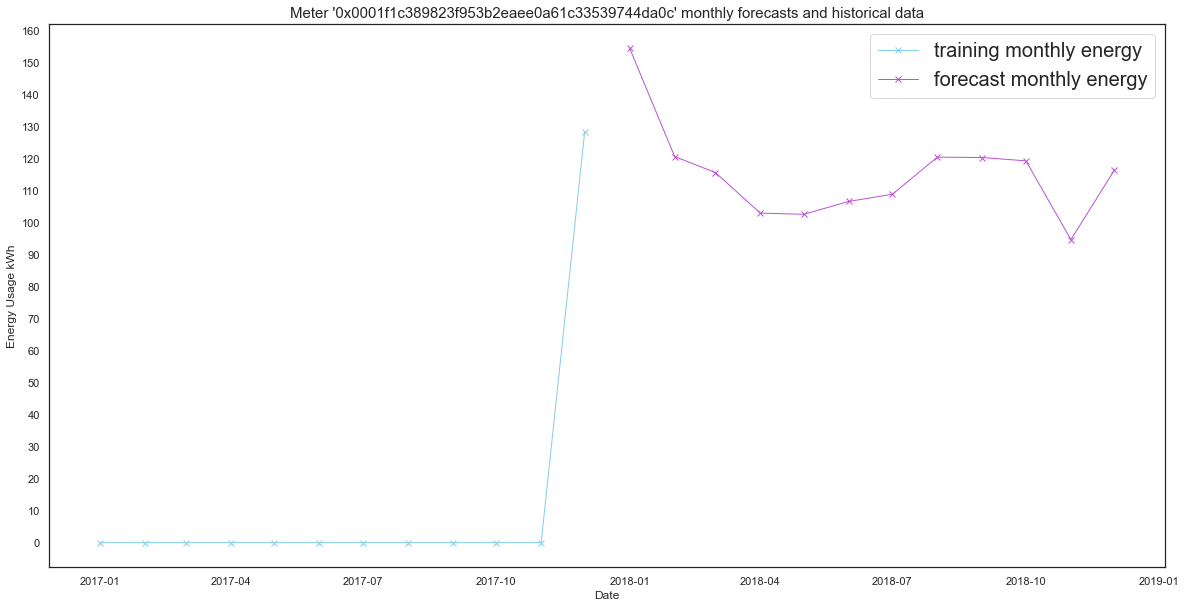

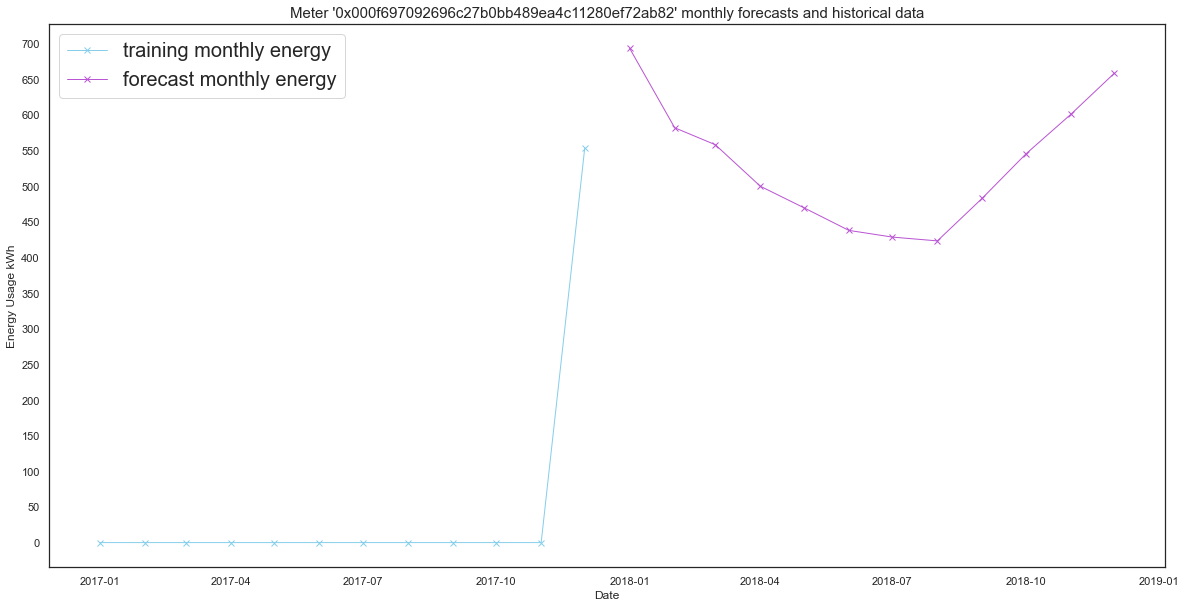

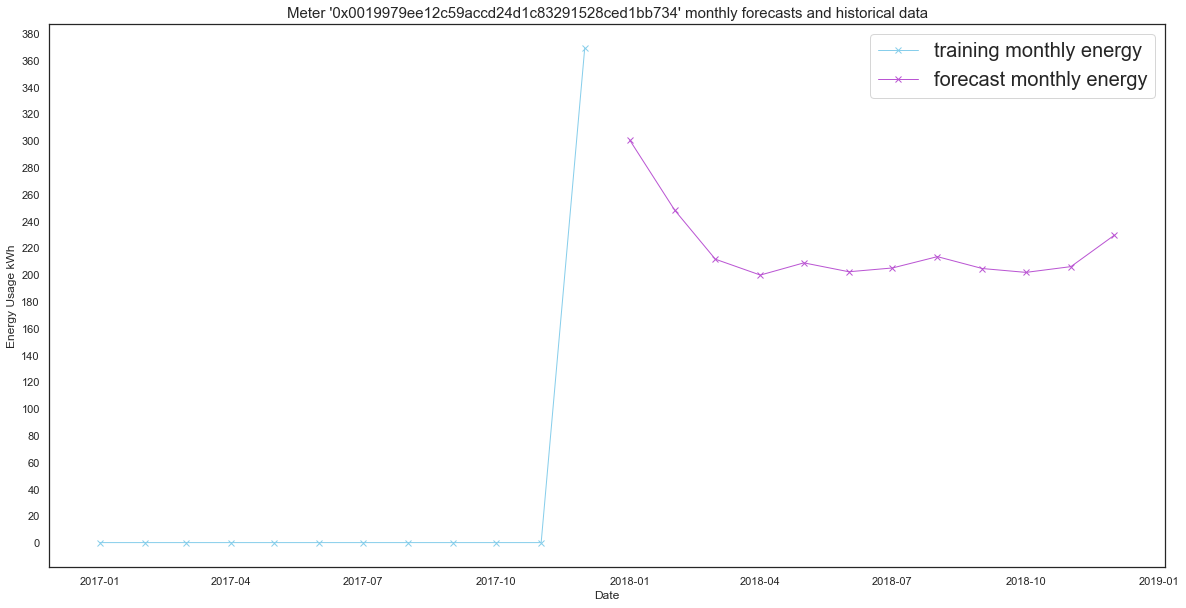

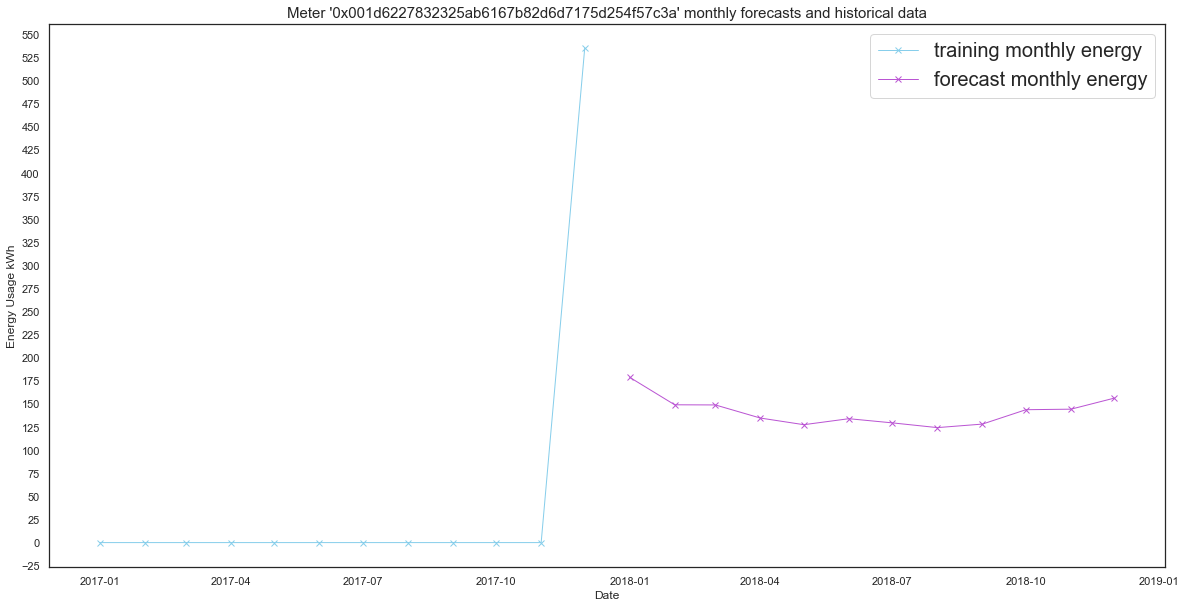

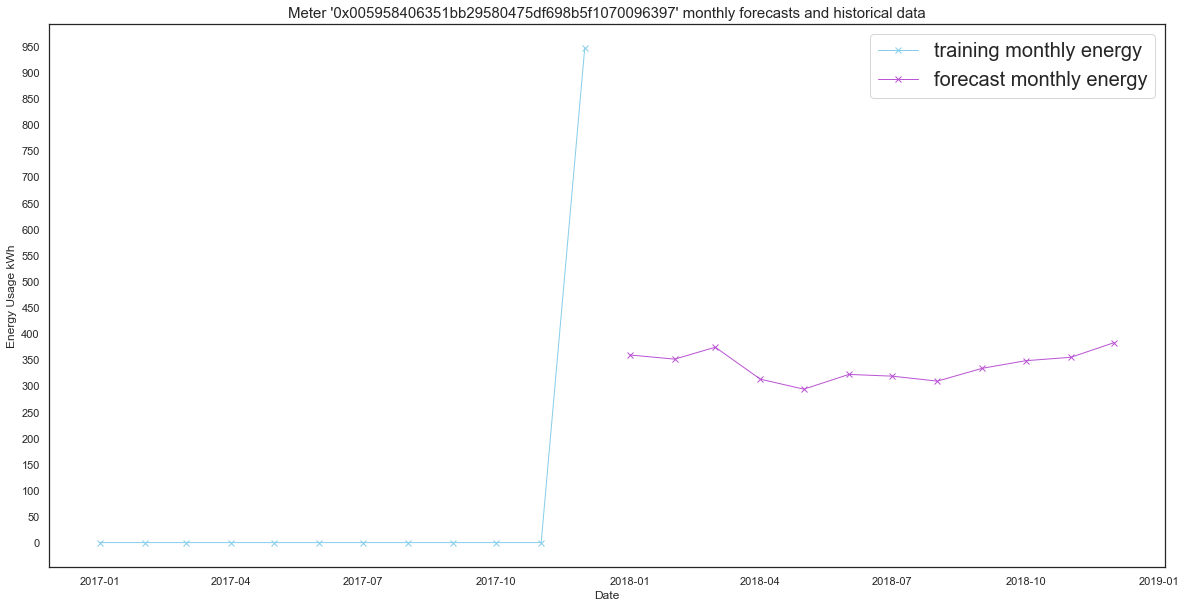

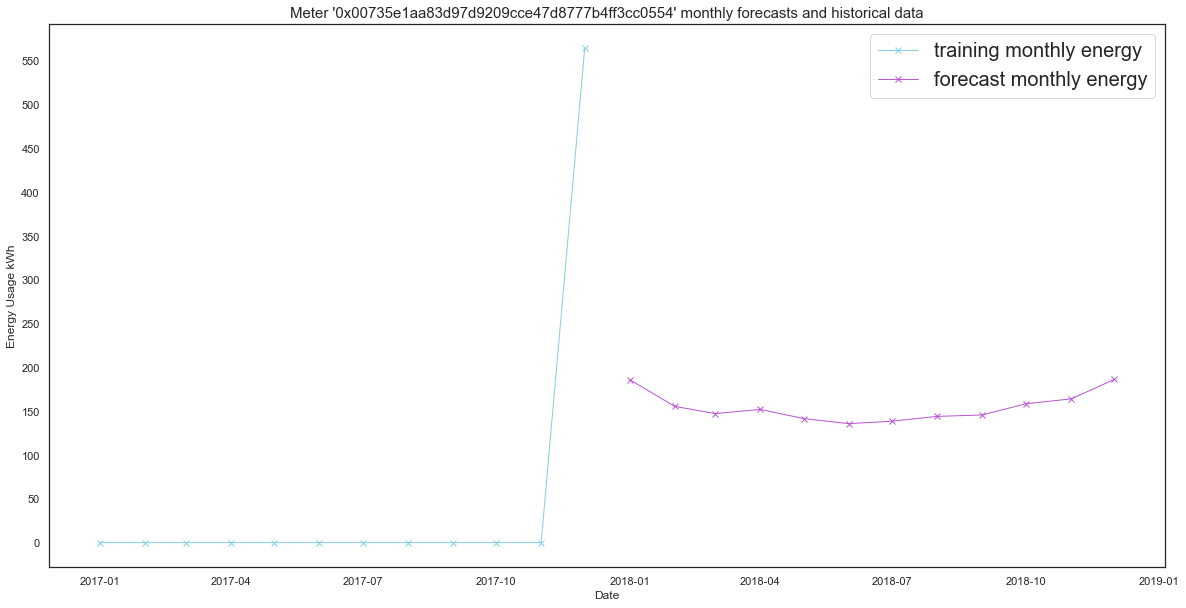

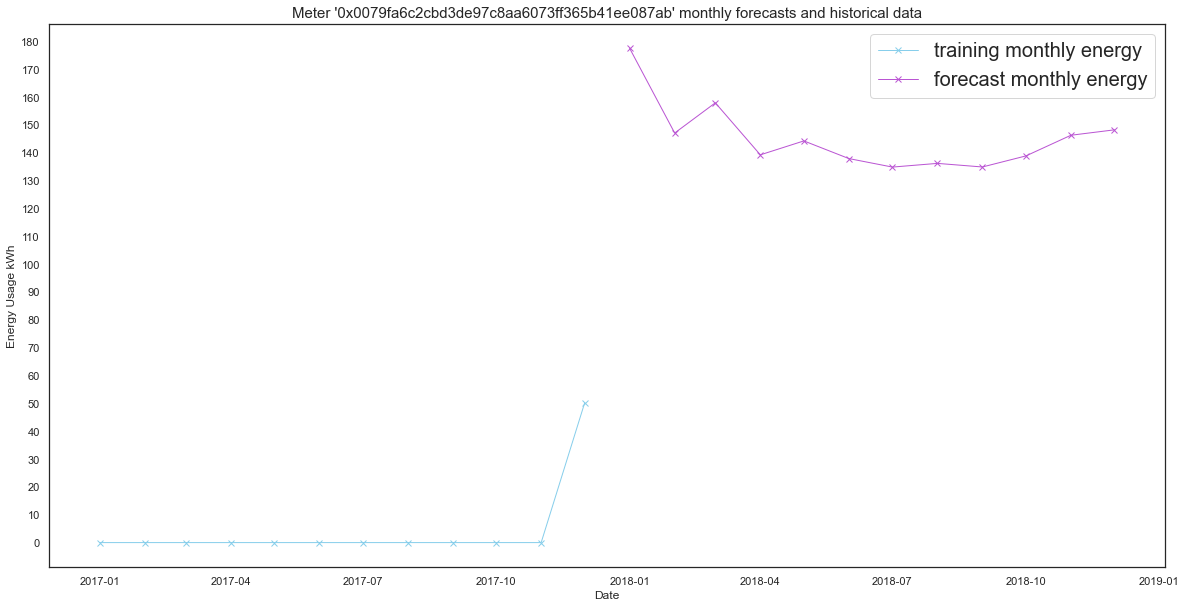

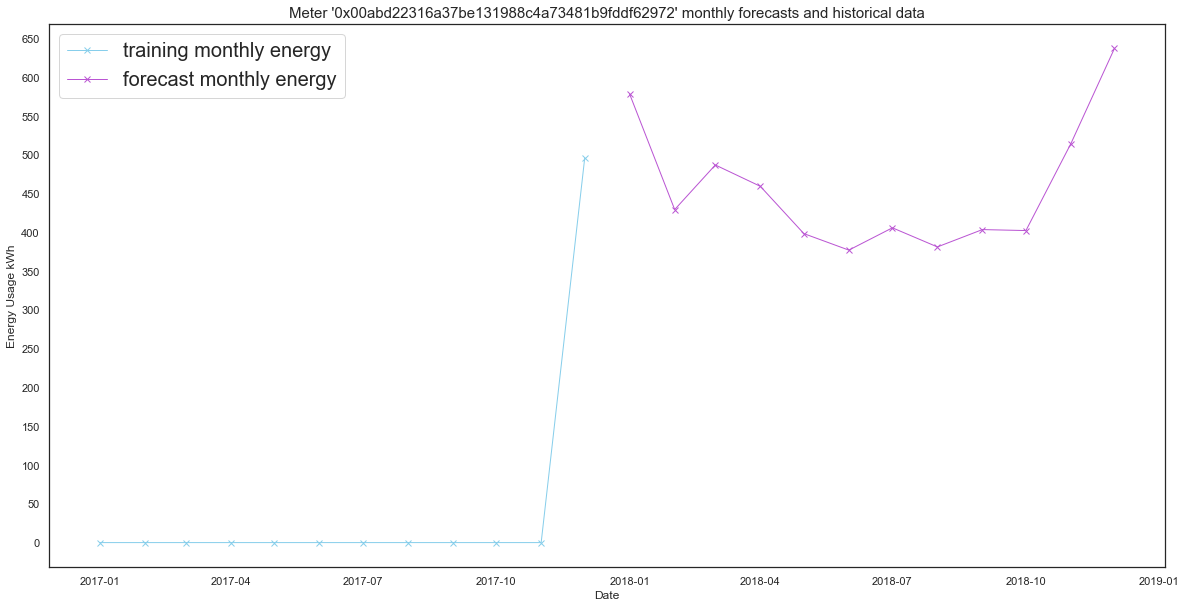

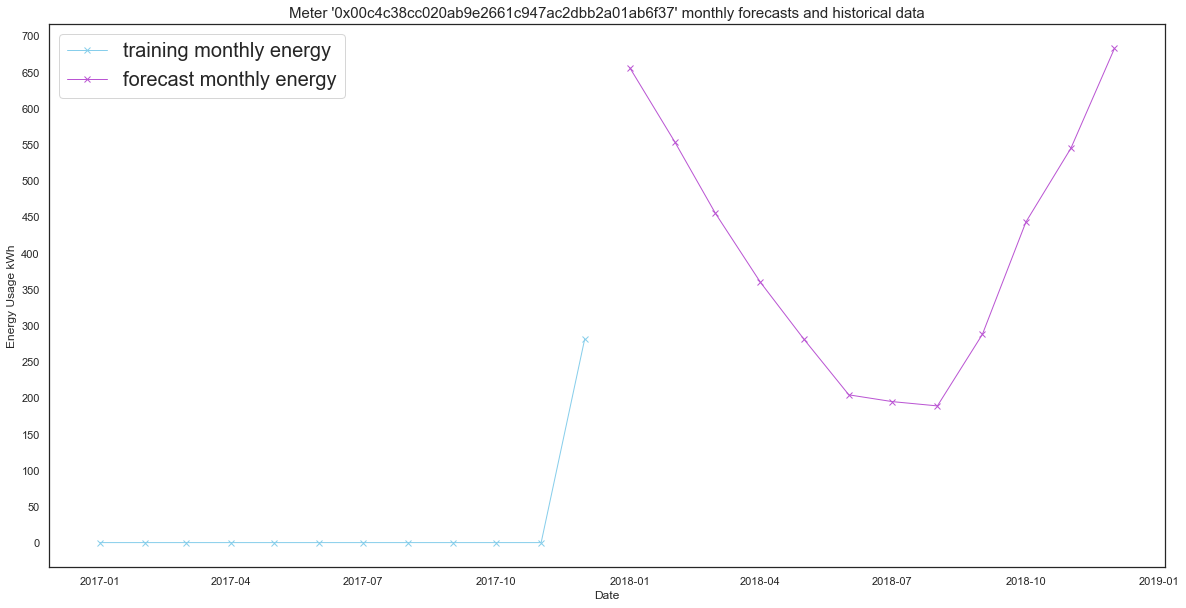

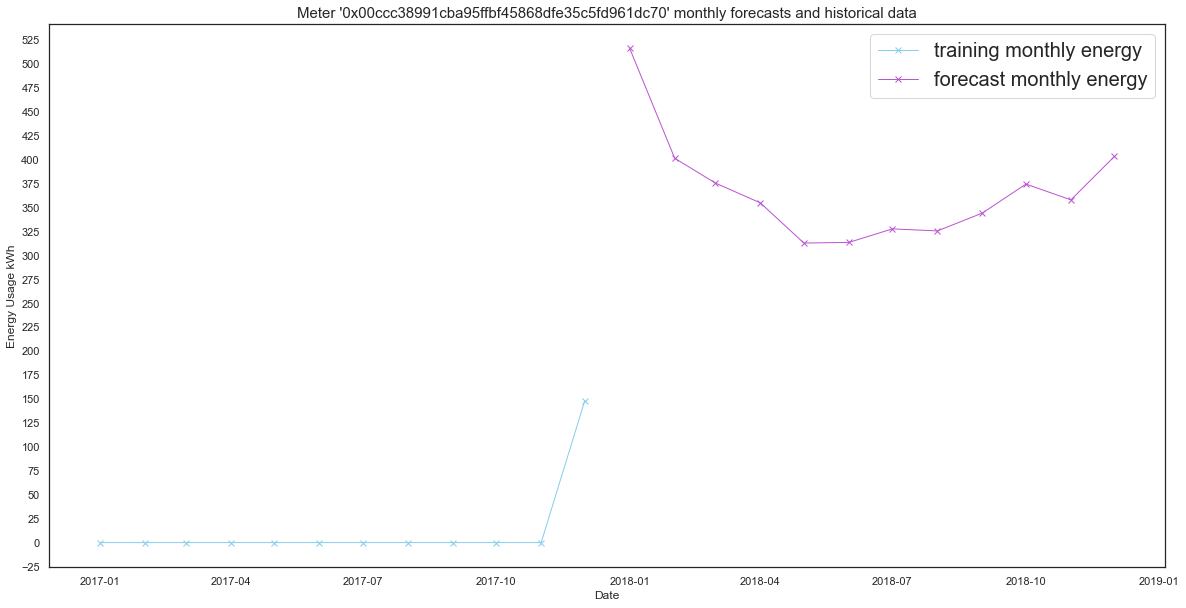

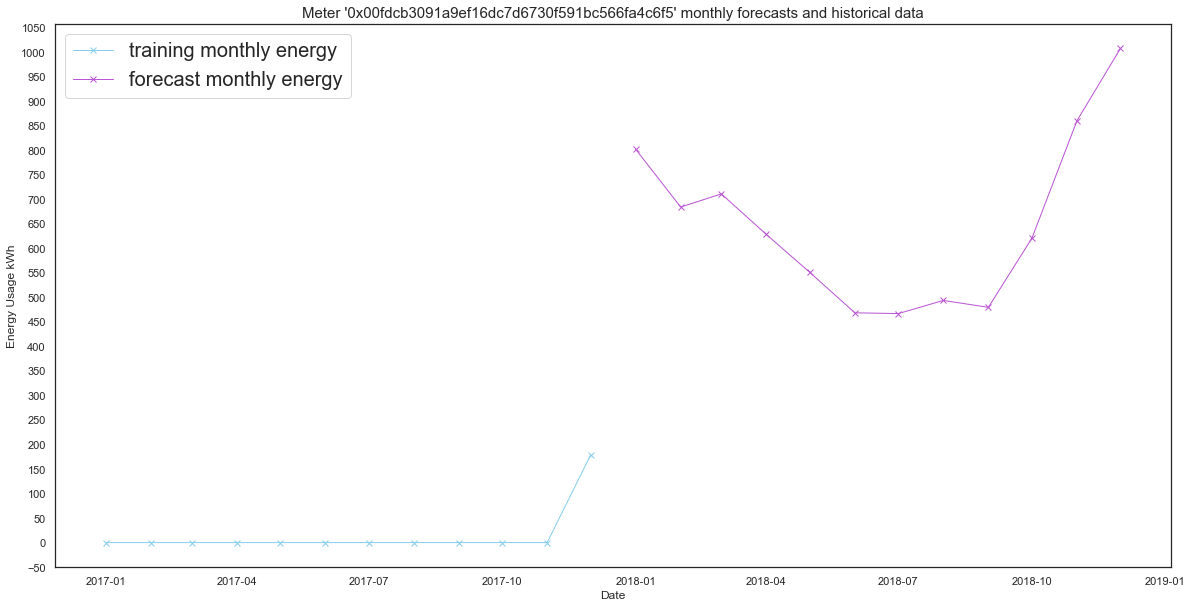

In [43]:
num_plots = 10
for pid in tqdm(range(0,3248)):
    if pid>num_plots:
        break
        
    #getting the row corresponding to this meter_id
    meter_id = df_daily_forecasts.iloc[pid,0]
    this_train_month = df_train_monthly.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_preds_month = df_monthly_forecasts.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    
    #converting index to datetime for ease of plots key
    this_train_month.index=pd.to_datetime(this_train_month.index)
    this_preds_month.index=pd.to_datetime(this_preds_month.index)
    
    #creating figure
    fig = plt.figure(figsize=(20,10))
    
    #plotting the monthly predictions
    plt.title("Meter '"+str(meter_id)+"' monthly forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_month, label="training monthly energy", lw=1,color="skyblue", marker="x")
    plt.plot(this_preds_month, label="forecast monthly energy", lw=1,color="mediumorchid", marker="x")
    
    #annotations
    plt.legend(fontsize=20)
    plt.locator_params(nbins=24)
    
    plt.show()
    fig.savefig(f"..\\Results\\Unclustered Random Search\\Plots\\forecasts\\main_effects\\{n}_forecasts_{pid}_{meter_id}.png")

    fig.clf()
    fig.clear()
    plt.close()
    del fig, this_train_month, this_preds_month
    gc.collect()